# Models predictions

In [1]:
import sys, os, glob
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import tensorflow as tf

from MRIsegm.metrics import dice_coef
from MRIsegm.losses import DiceBCEloss, soft_dice_loss
from MRIsegm.methods import create_segmentation_generator, show_dataset, show_prediction
from tensorflow.keras.models import load_model

### Constants

In [2]:
SEED = 3

IMAGE_HEIGHT = 128
IMAGE_WIDTH =  128
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir_validation = '../data/validation'
data_dir_validation_img = os.path.join(data_dir_validation, 'img')
data_dir_validation_mask = os.path.join(data_dir_validation, 'mask')

data_dir_training = '../data/training'
data_dir_train_img = os.path.join(data_dir_training, 'img')
data_dir_train_mask = os.path.join(data_dir_training, 'mask')

models_dir = '../data/models'
models_path = glob.glob(models_dir + '/*.h5')

dependencies = {
    'DiceBCEloss': DiceBCEloss,
    'dice_coef': dice_coef,
    'soft_dice_loss':soft_dice_loss
    
}

keys = [ os.path.splitext(os.path.split(models_path[i])[1])[0] for i, mod in enumerate(models_path)]
values = [ load_model(models_path[i], custom_objects=dependencies) for i, mod in enumerate(models_path)]

models = dict(zip(keys, values))


In [3]:
def display_predictions(display_list, keys, colormap=True, cmap='gist_heat',figsize=(25,15) ):
    plt.figure(figsize=figsize, constrained_layout=True)
    title = ['True Mask'] + keys
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        
        plt.title(title[i])
        if i >= 1 and colormap==True:
            ax = plt.gca()
            
            im = ax.imshow((display_list[i]), cmap=cmap, vmin=0.0, vmax=1.0)
            if i == len(display_list) - 1:

                axins = inset_axes(ax, width = "5%", height = "100%", loc = 'lower left',
                    bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax.transAxes,
                    borderpad = 0)
                
                plt.colorbar(im, cax=axins)
            
        else:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray') # optional: tf.keras.preprocessing.image.array_to_img, just to rescale from 0.-1. to 0-255
    
    plt.show()

In [4]:
def show_multiple_predictions(datagen, keys, values, num=1, colormap=True, cmap='gist_heat', figsize=(25,15)):
    for i in range(0, num):
        image, mask = next(datagen)
        
        pred_masks = [model.predict(image) for model in values]
        disp_list = [mask[0]]+[pred_masks[j][0] for j in range(len(pred_masks)) ]
        display_predictions( disp_list, keys, colormap, cmap, figsize)
        plt.show()

In [5]:
data_gen_args_img = data_gen_args_mask = dict(rescale=1./255)

validation_generator = create_segmentation_generator(data_dir_validation_img, data_dir_validation_mask, 1, IMG_SIZE, SEED, data_gen_args_img, data_gen_args_mask)

training_generator = create_segmentation_generator(data_dir_train_img, data_dir_train_mask, 1, IMG_SIZE, SEED, data_gen_args_img, data_gen_args_mask)

Found 42 images belonging to 1 classes.
Found 42 images belonging to 1 classes.
Found 444 images belonging to 1 classes.
Found 444 images belonging to 1 classes.


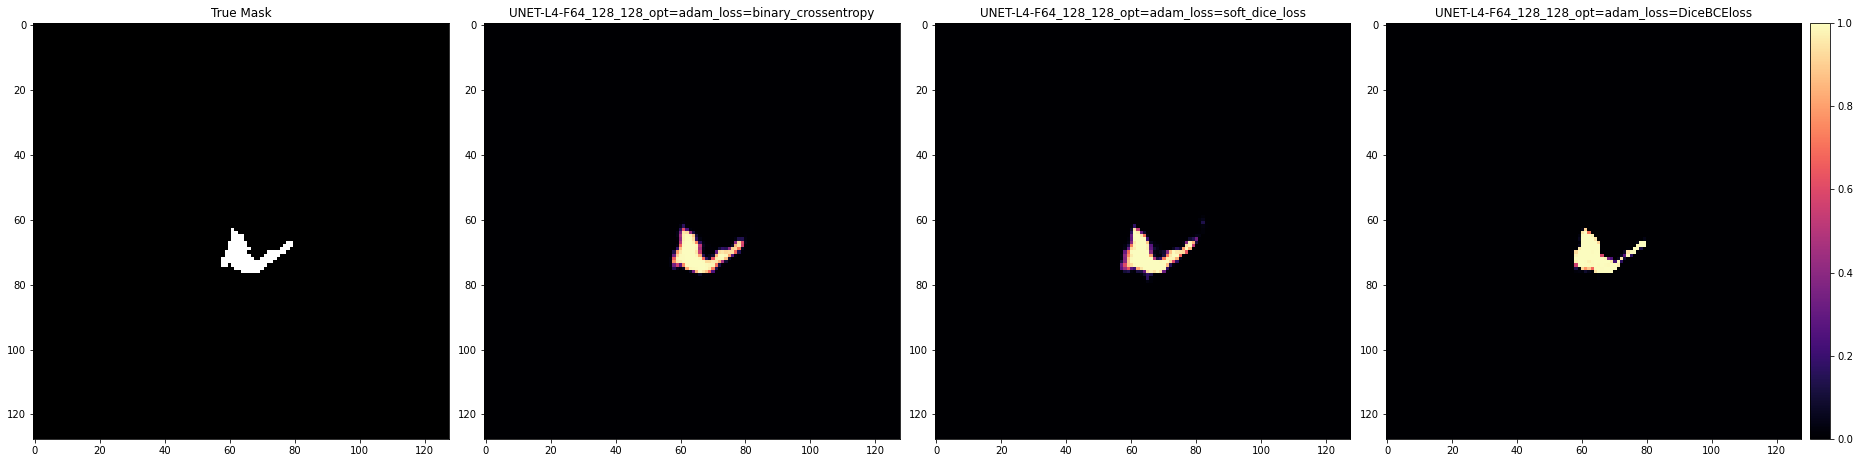

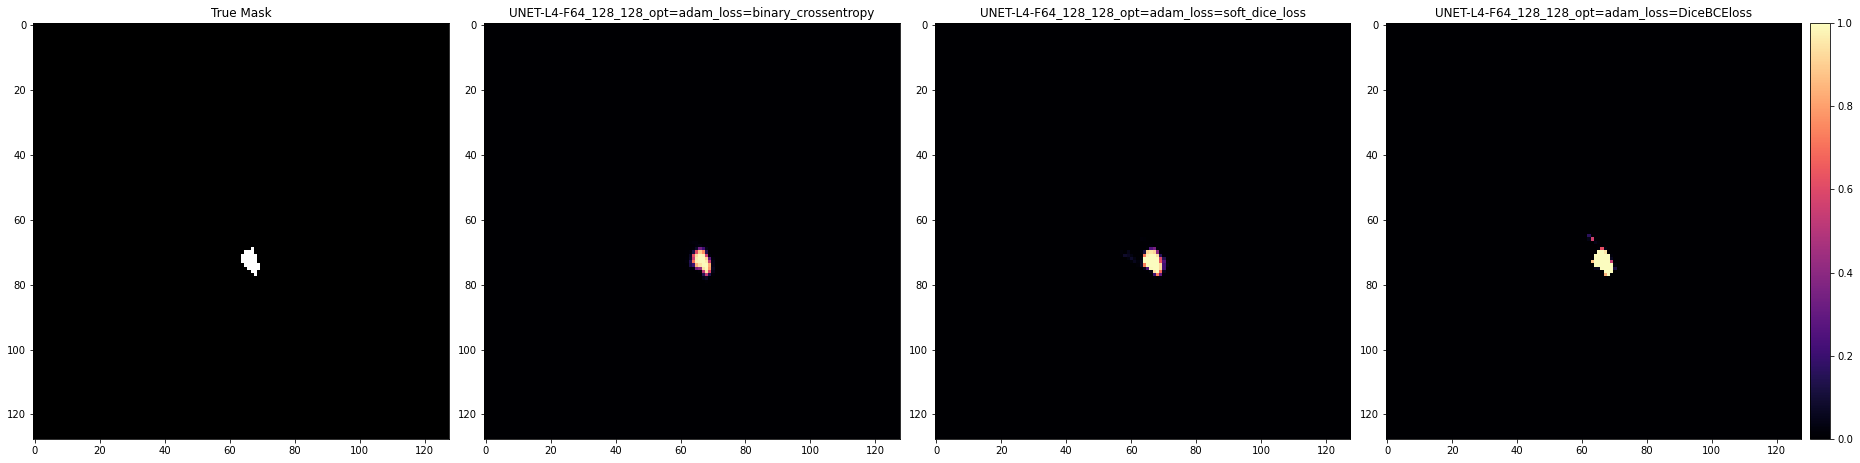

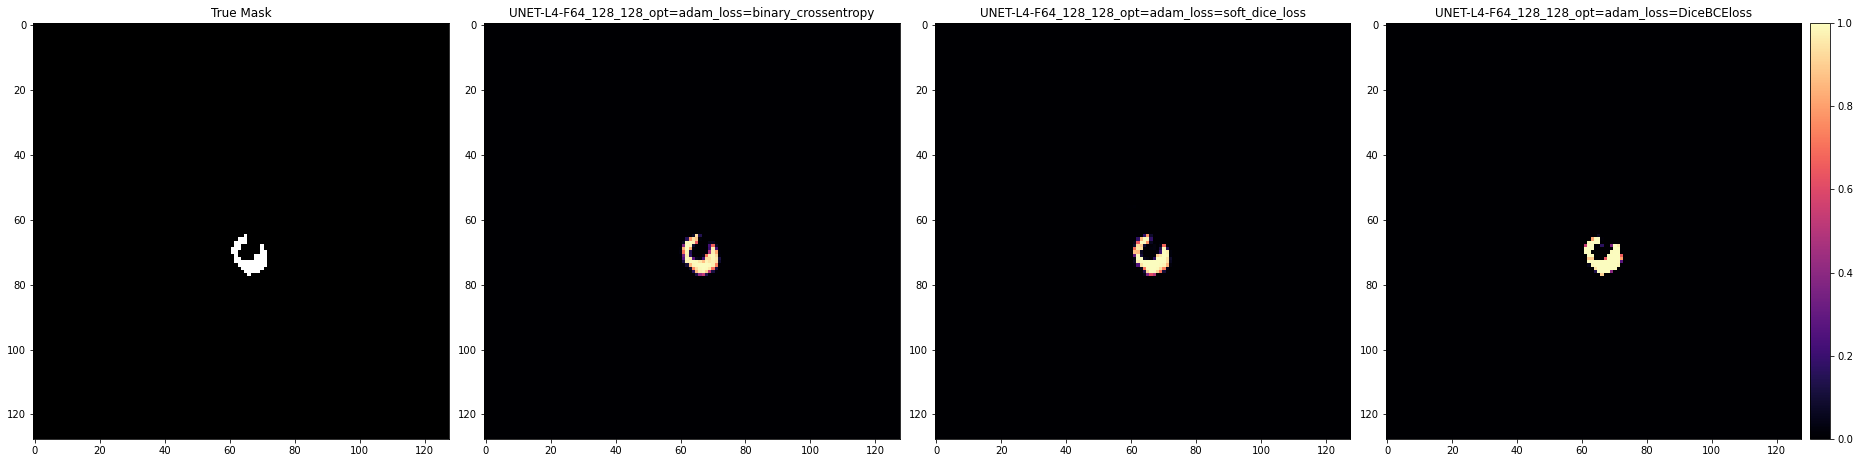

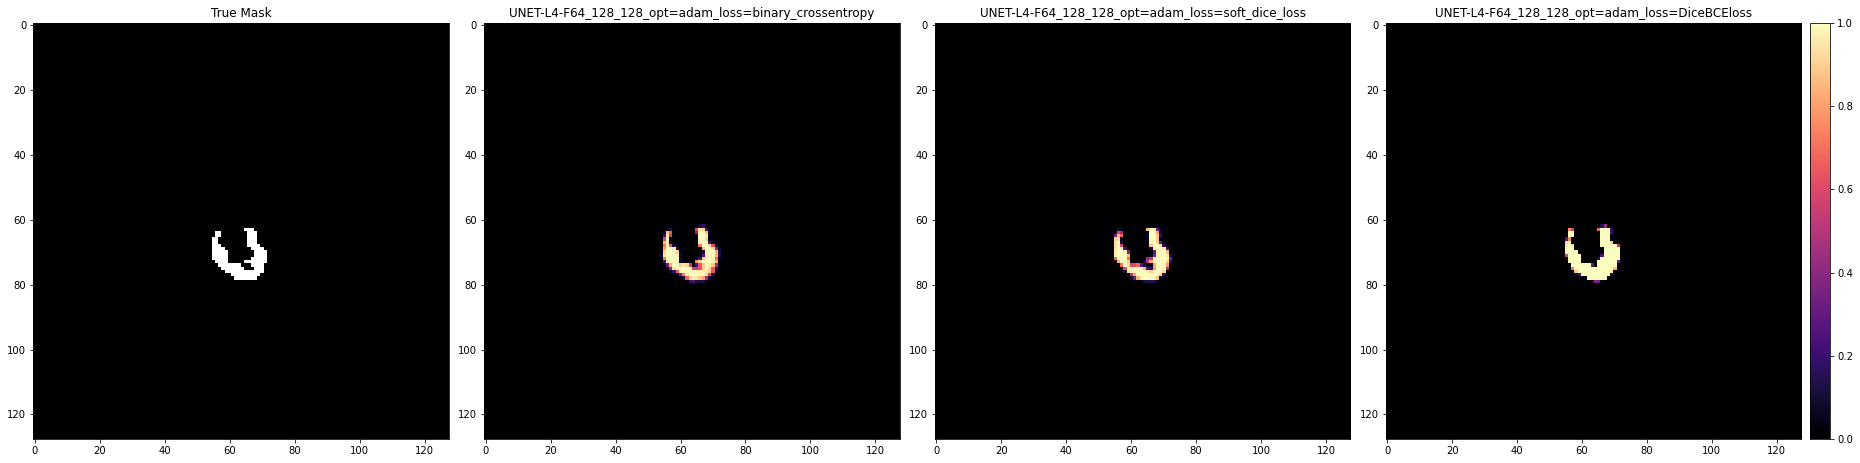

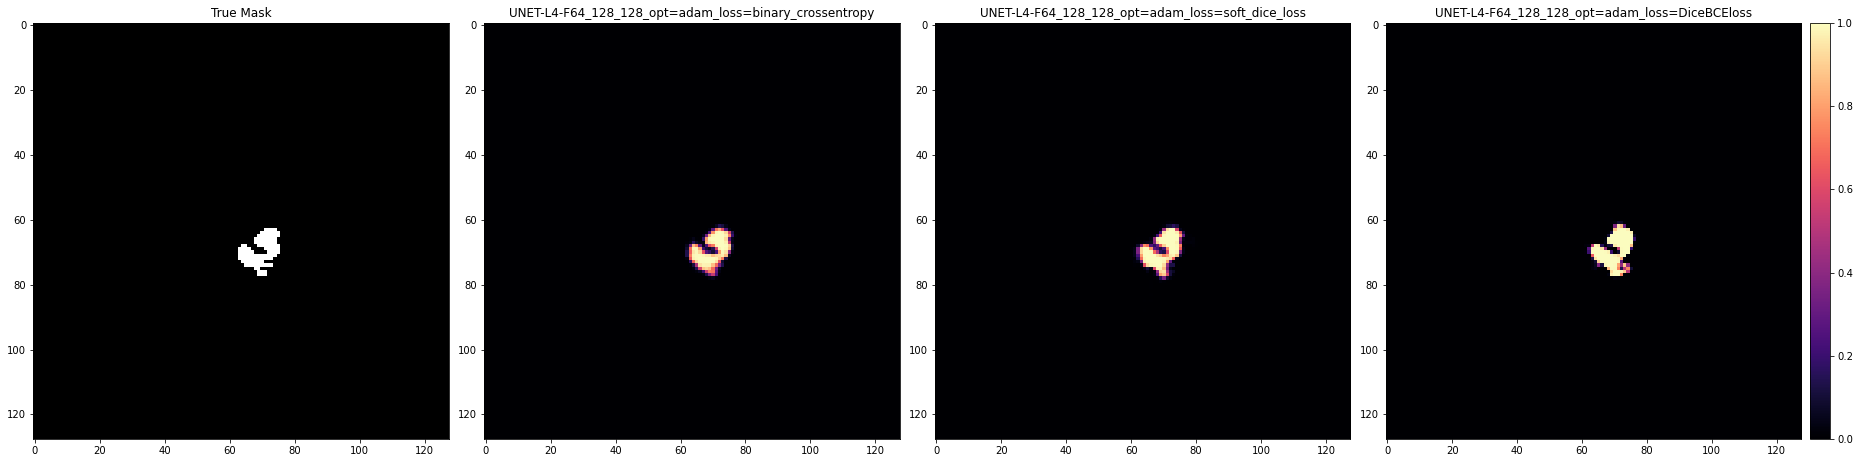

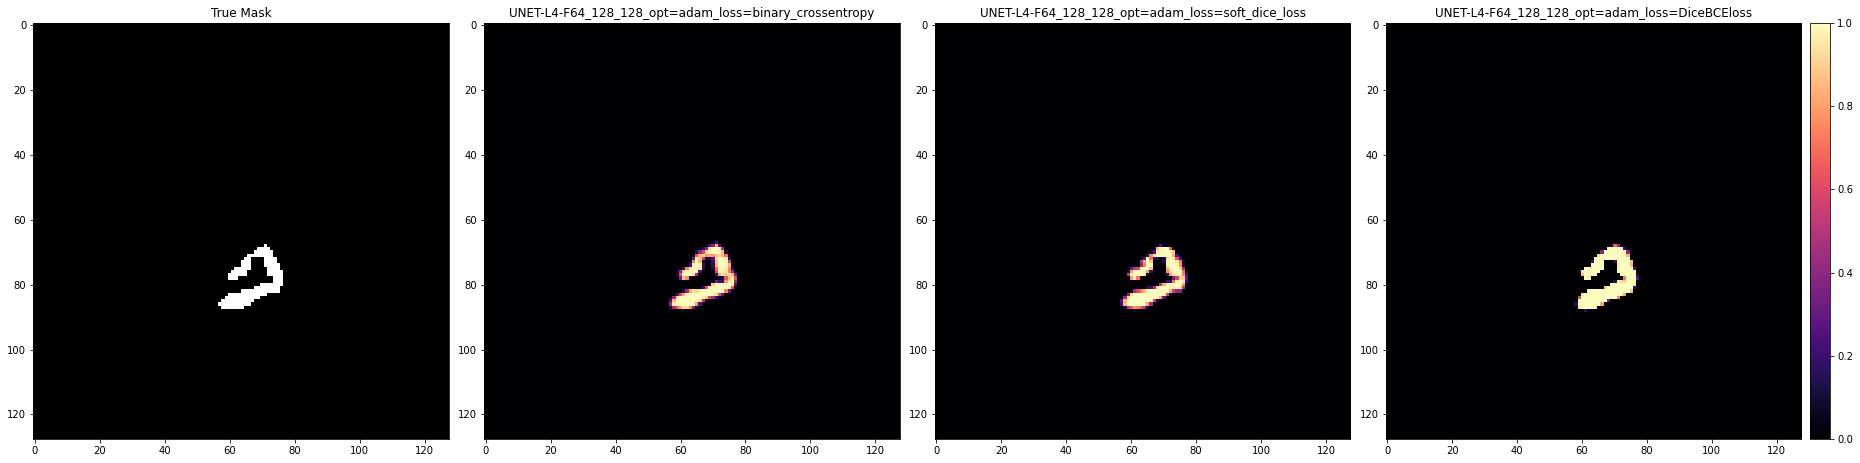

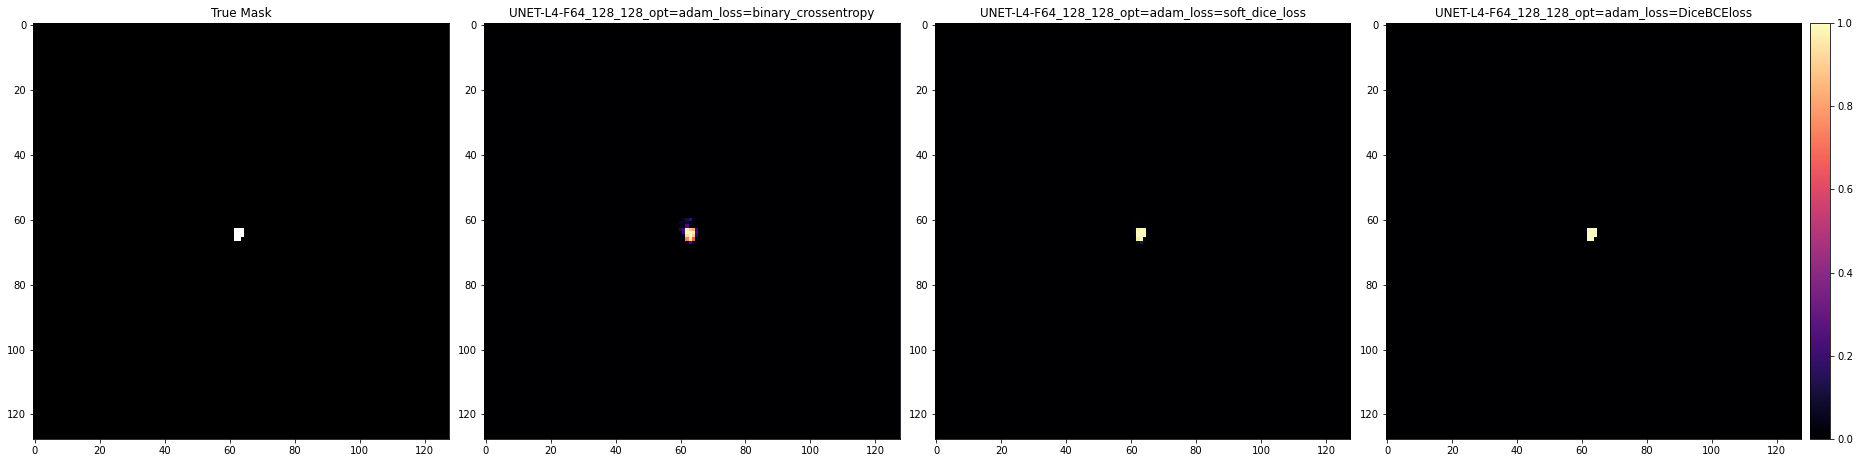

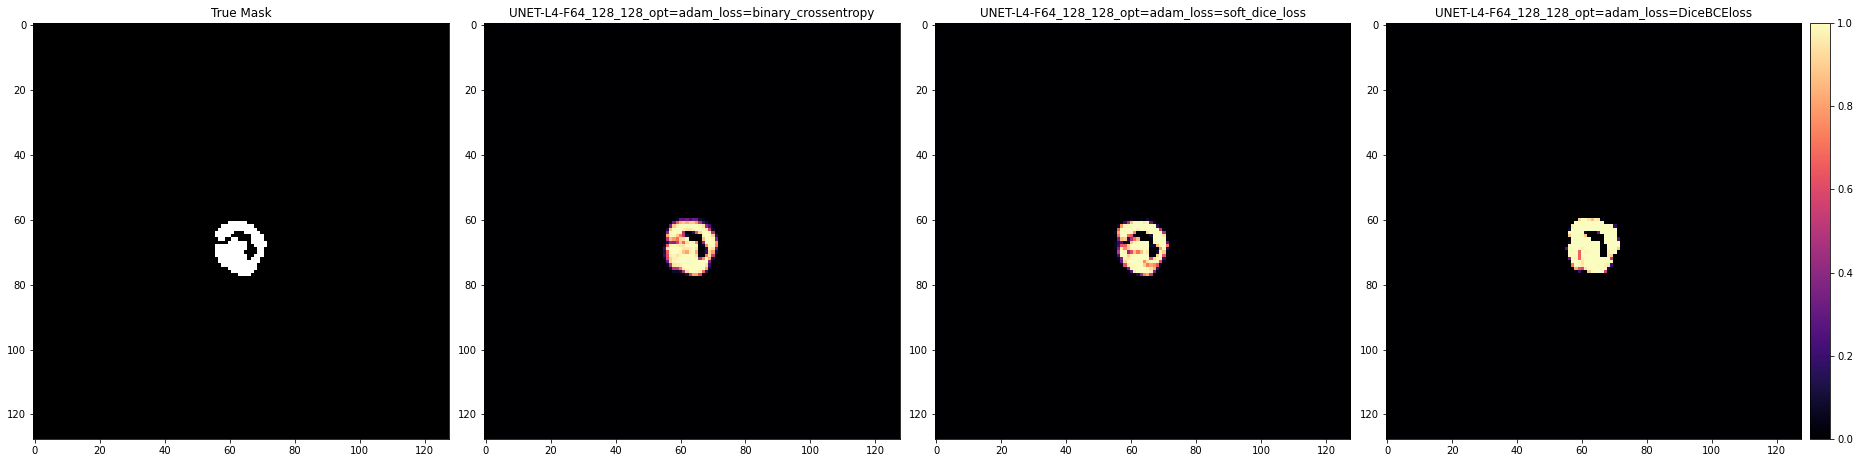

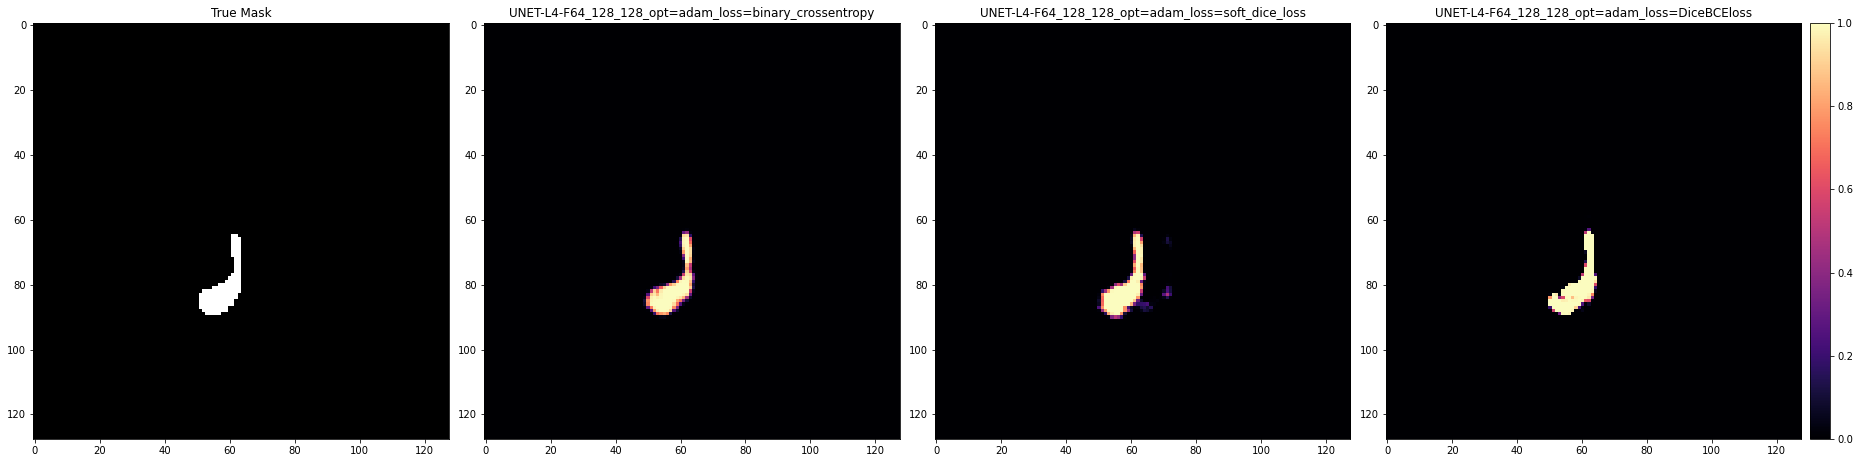

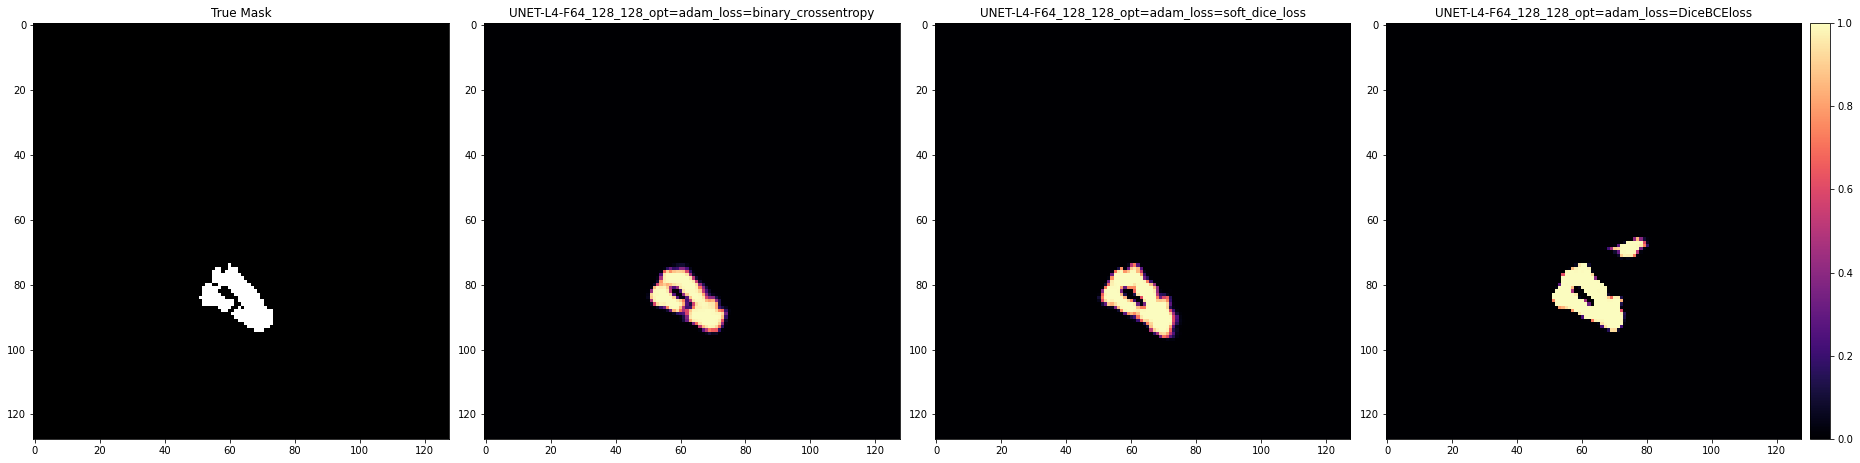

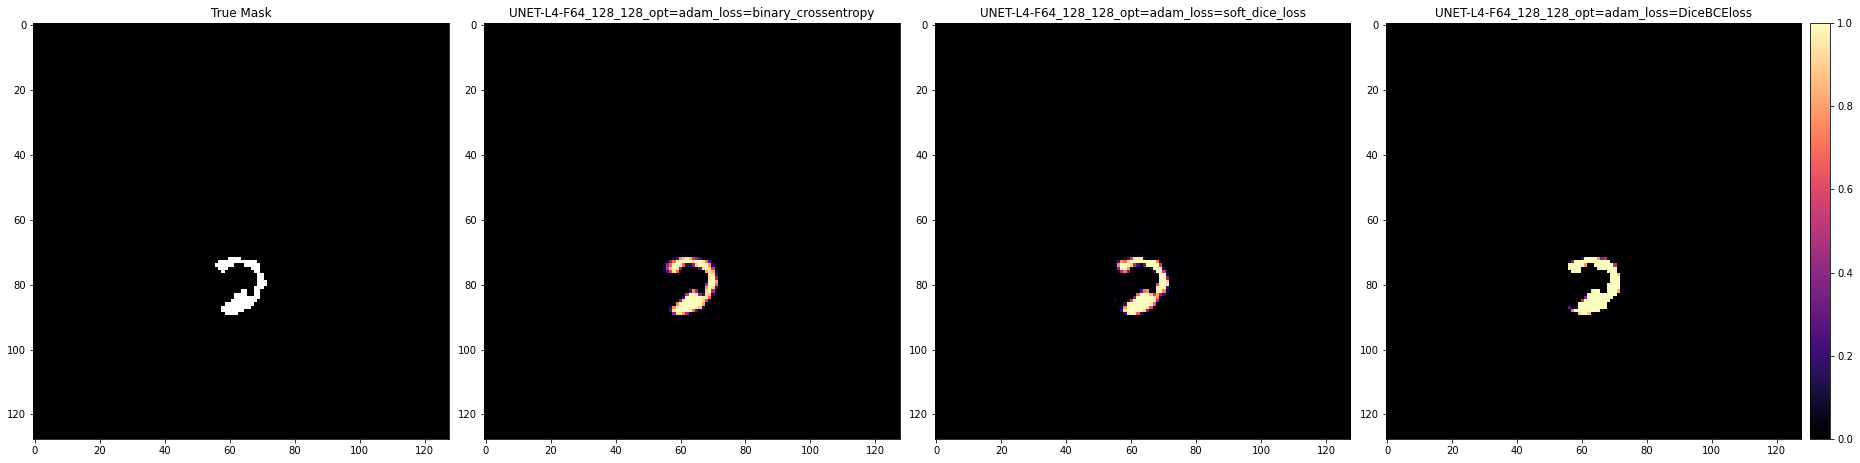

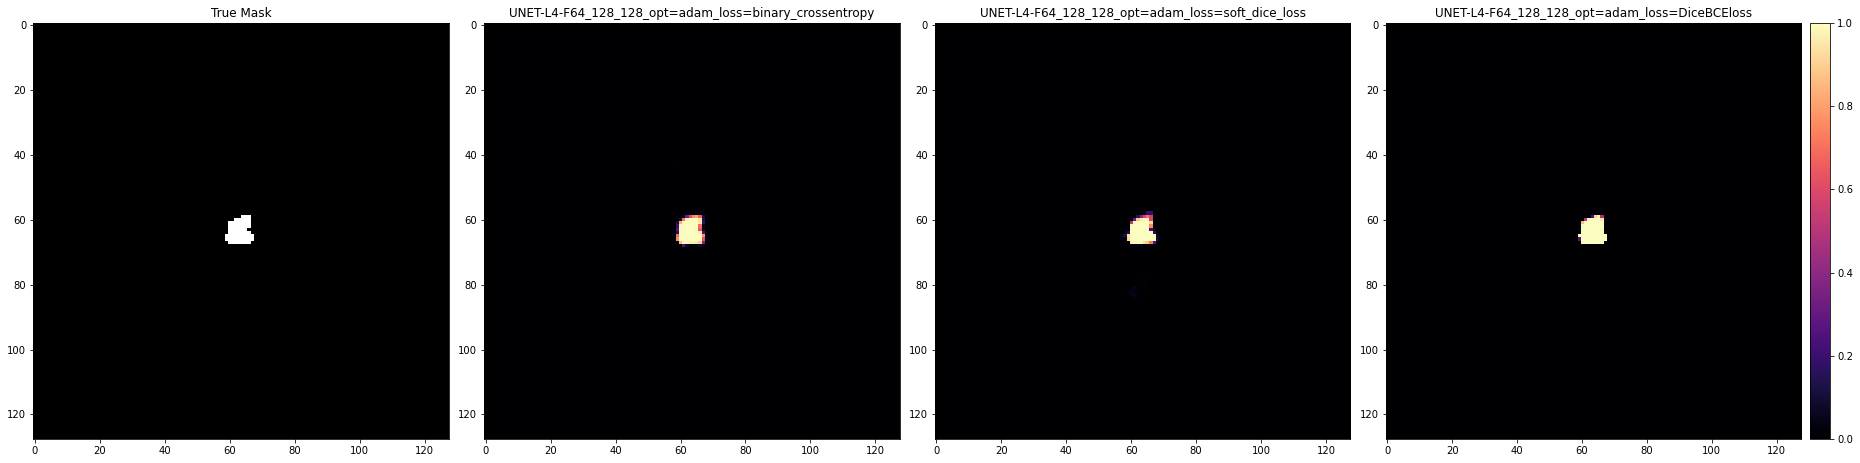

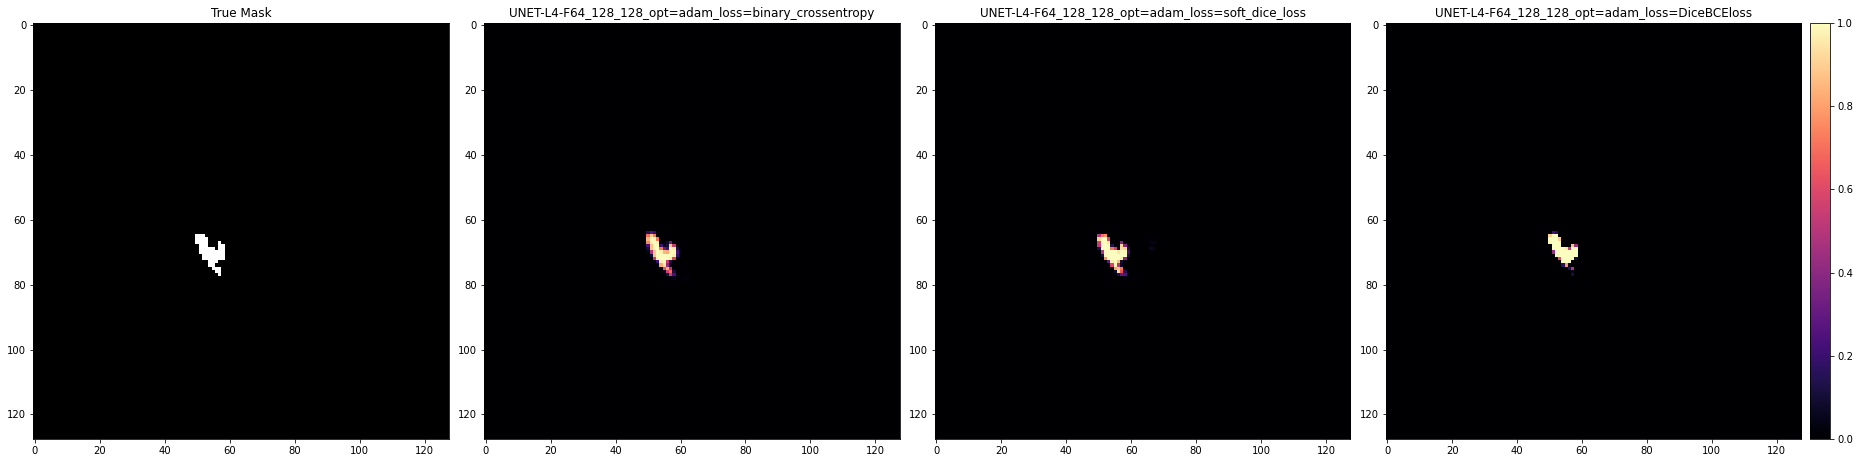

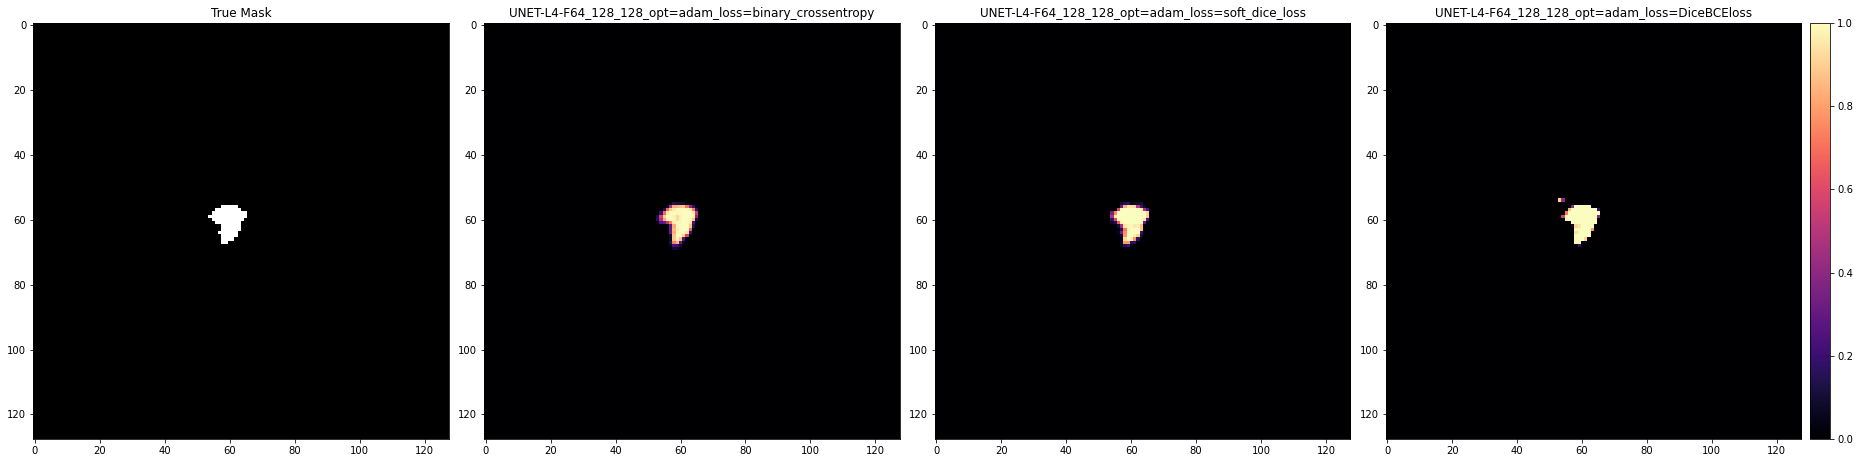

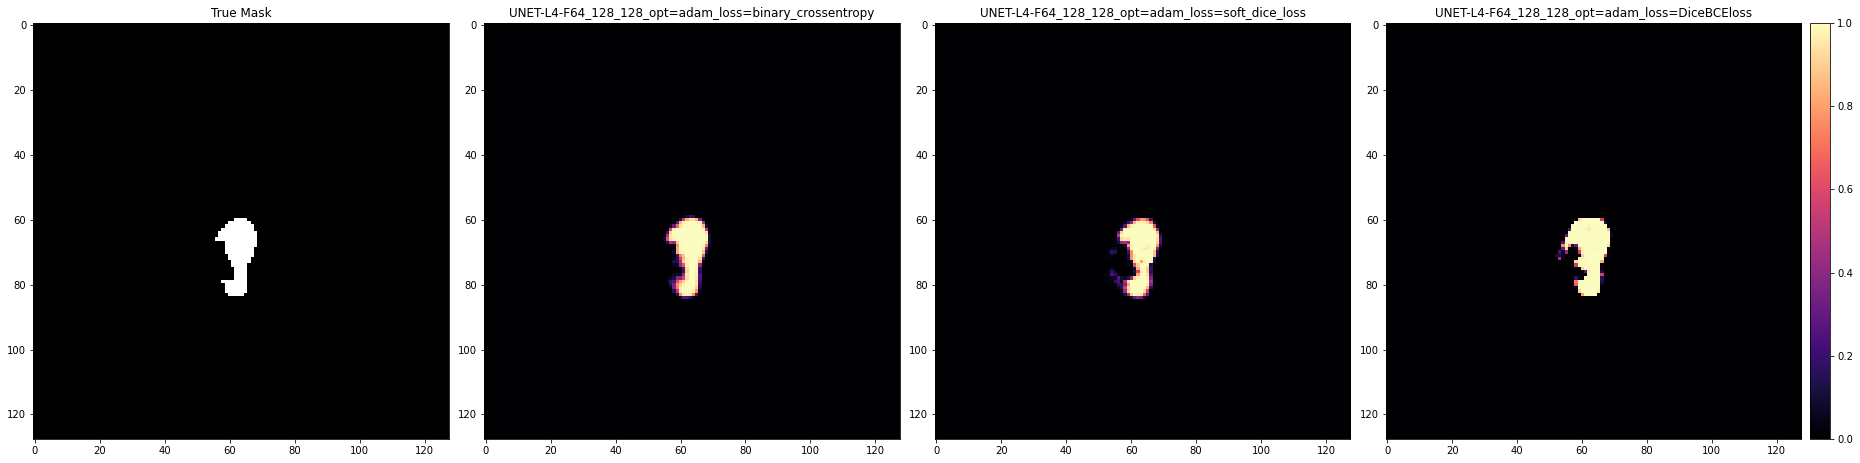

In [6]:
show_multiple_predictions(training_generator, keys, values, 15, cmap='magma')

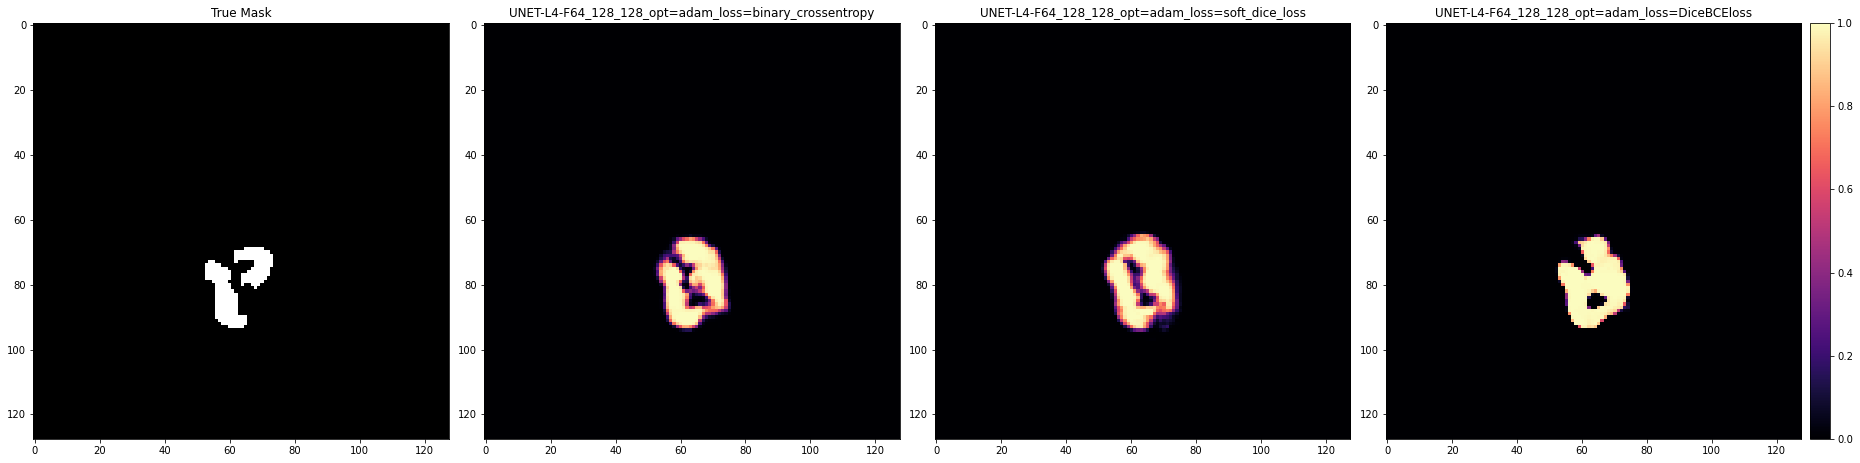

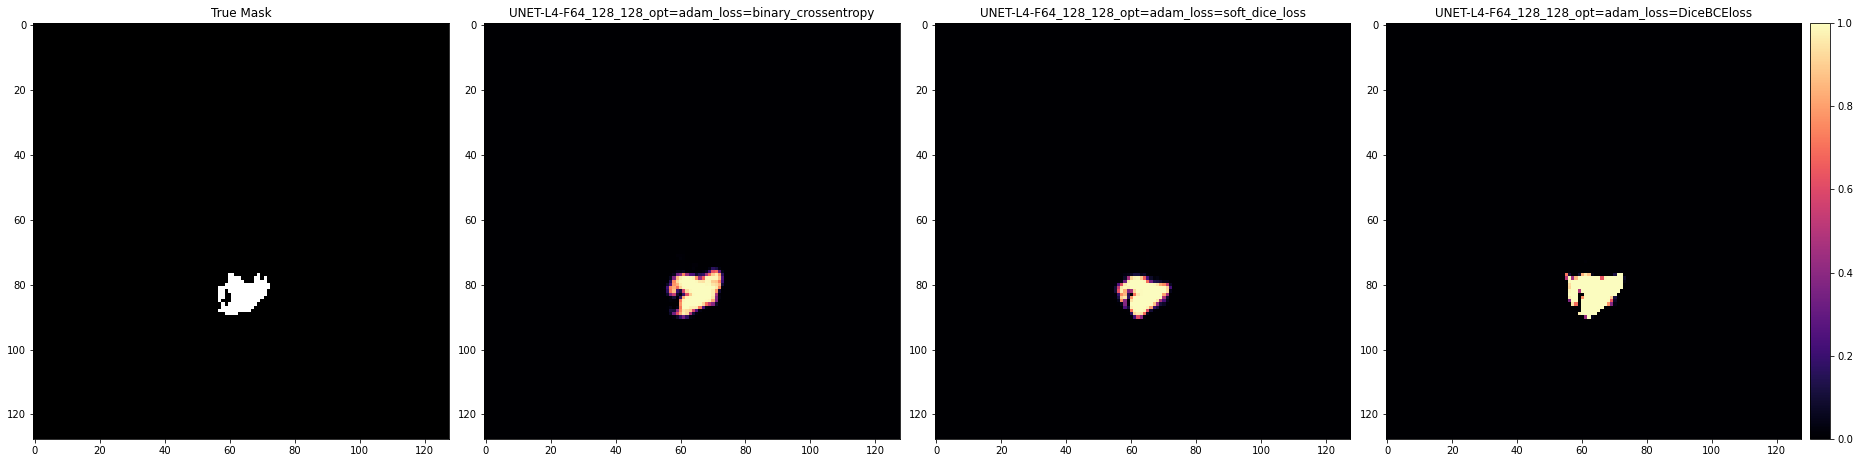

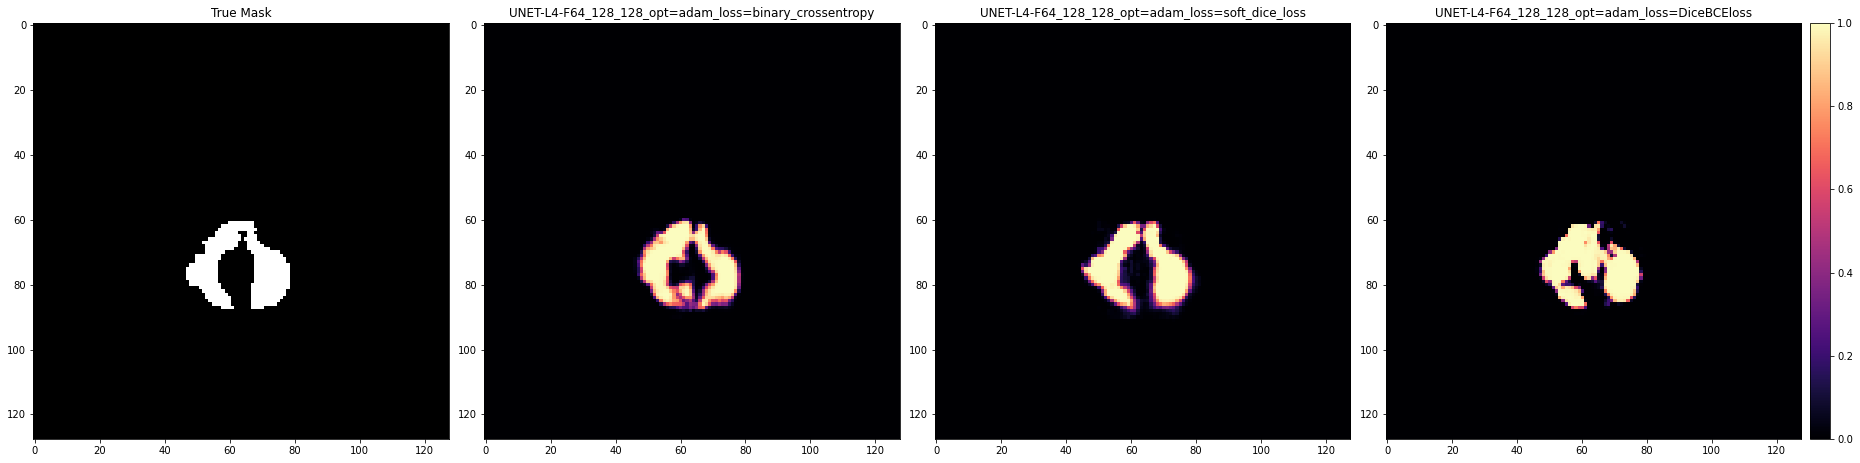

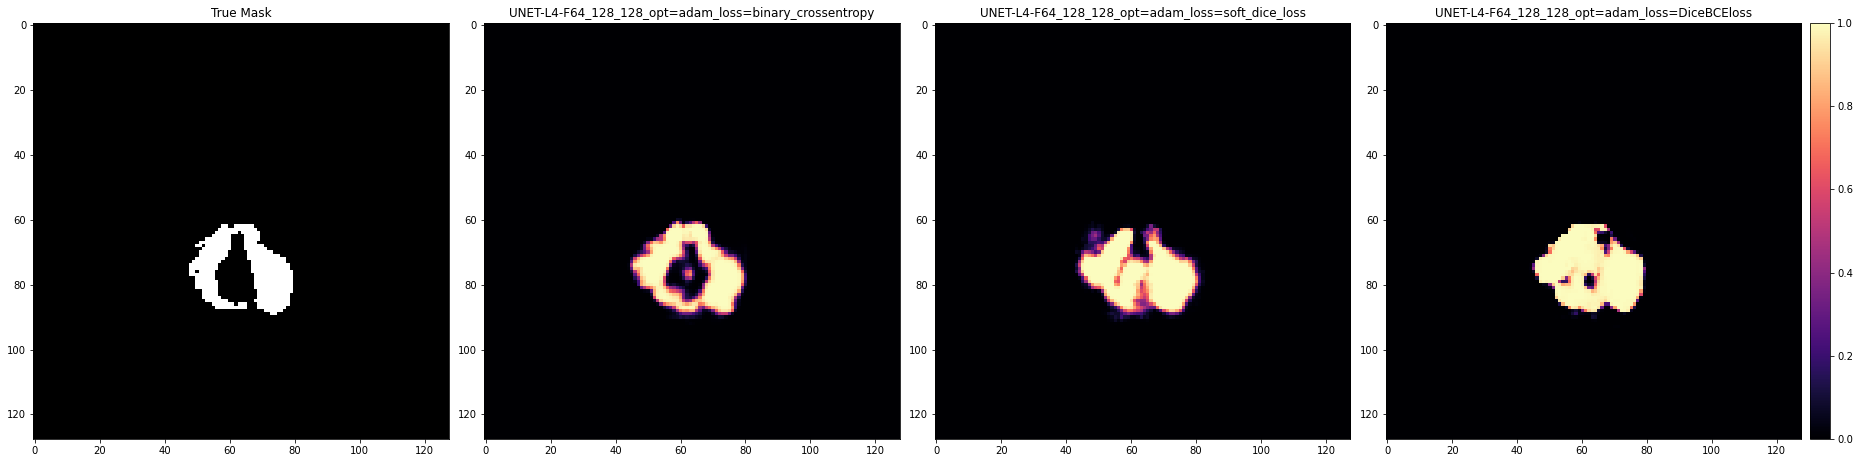

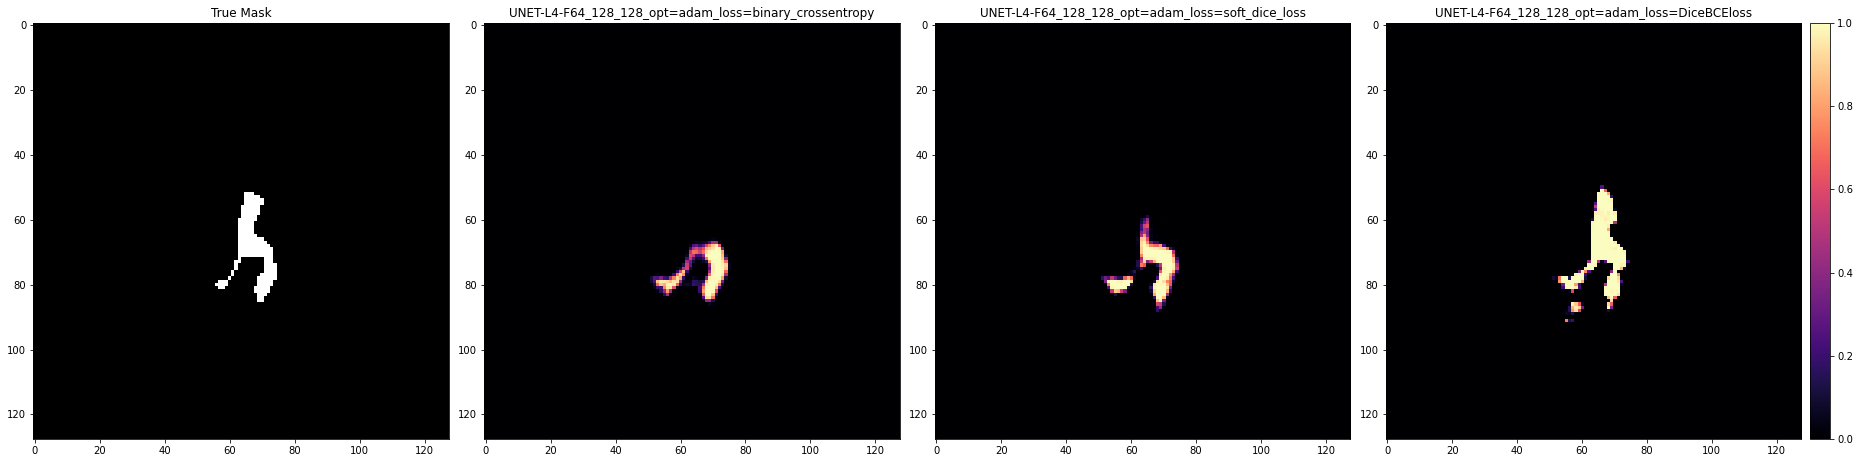

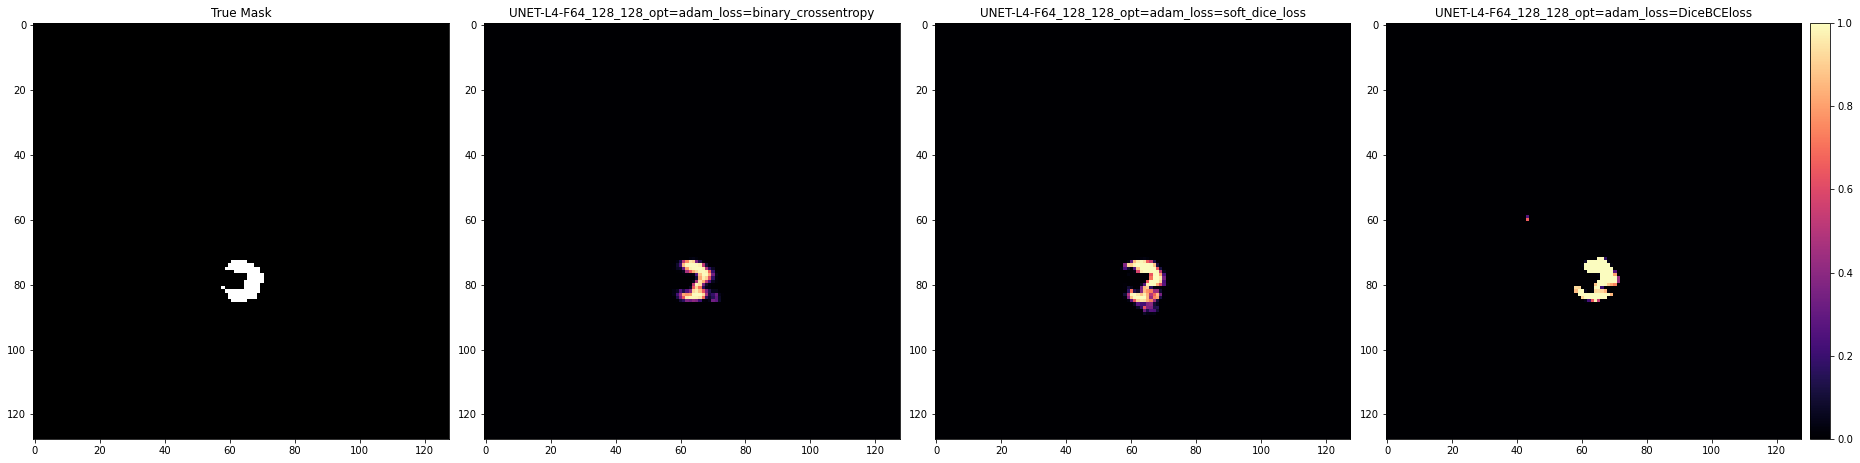

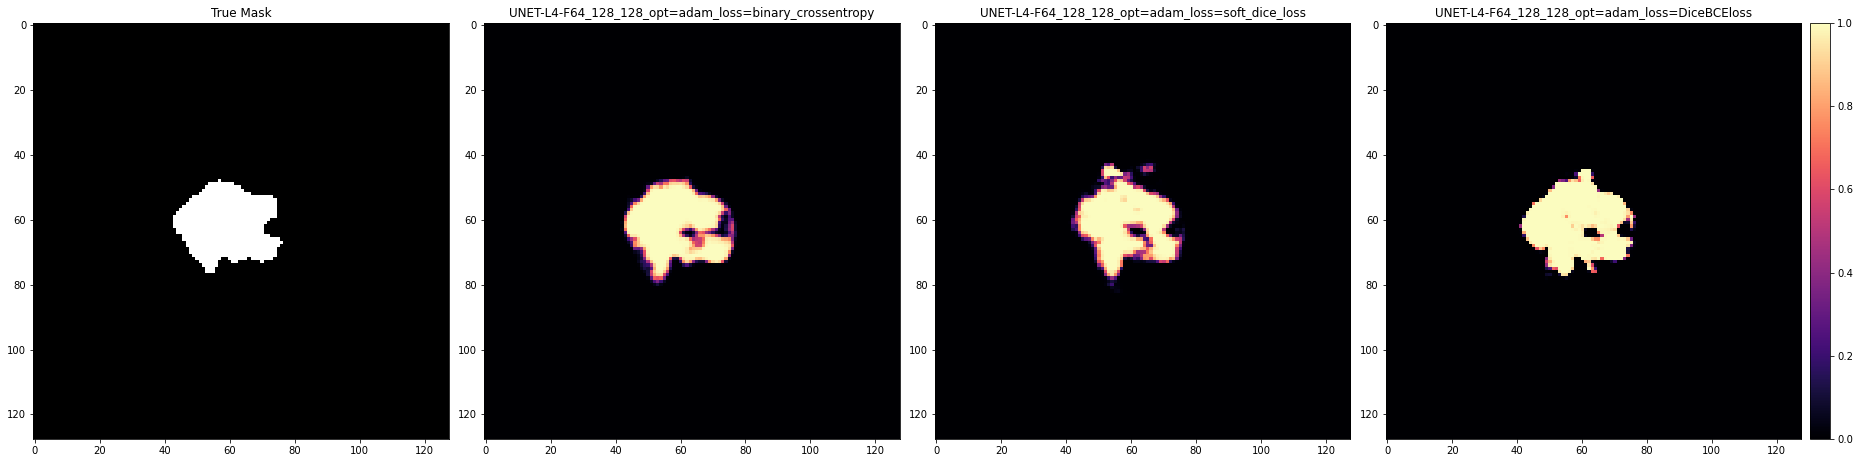

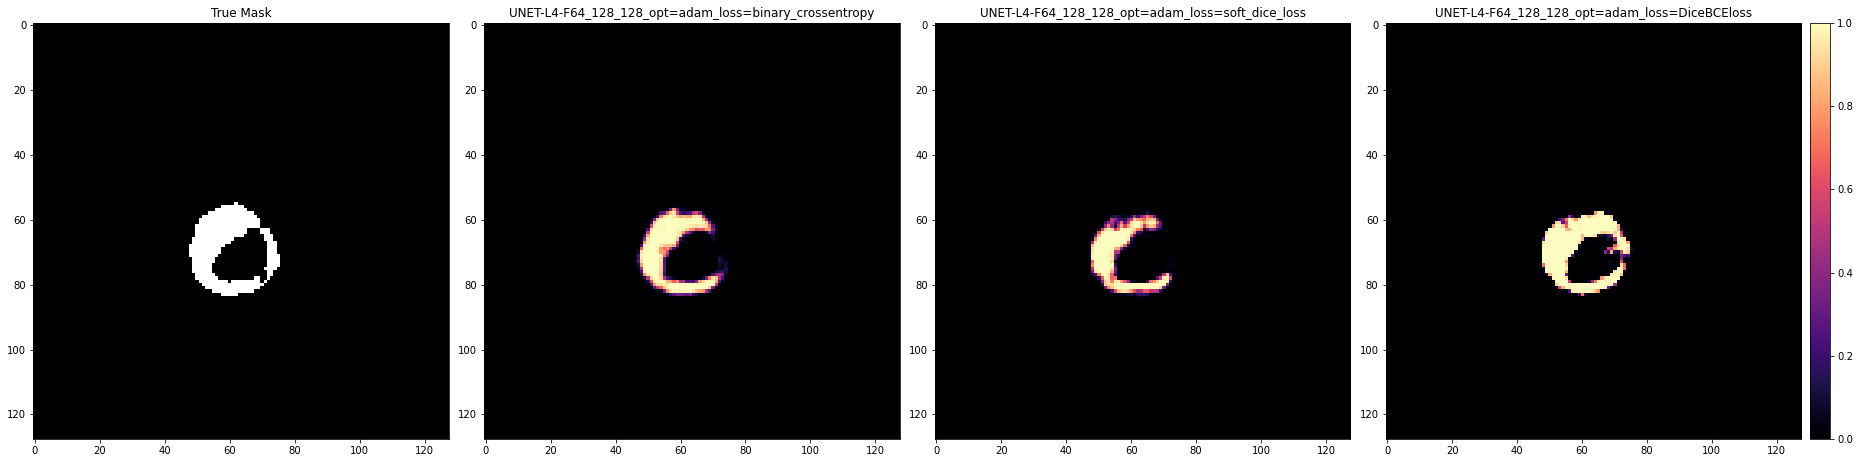

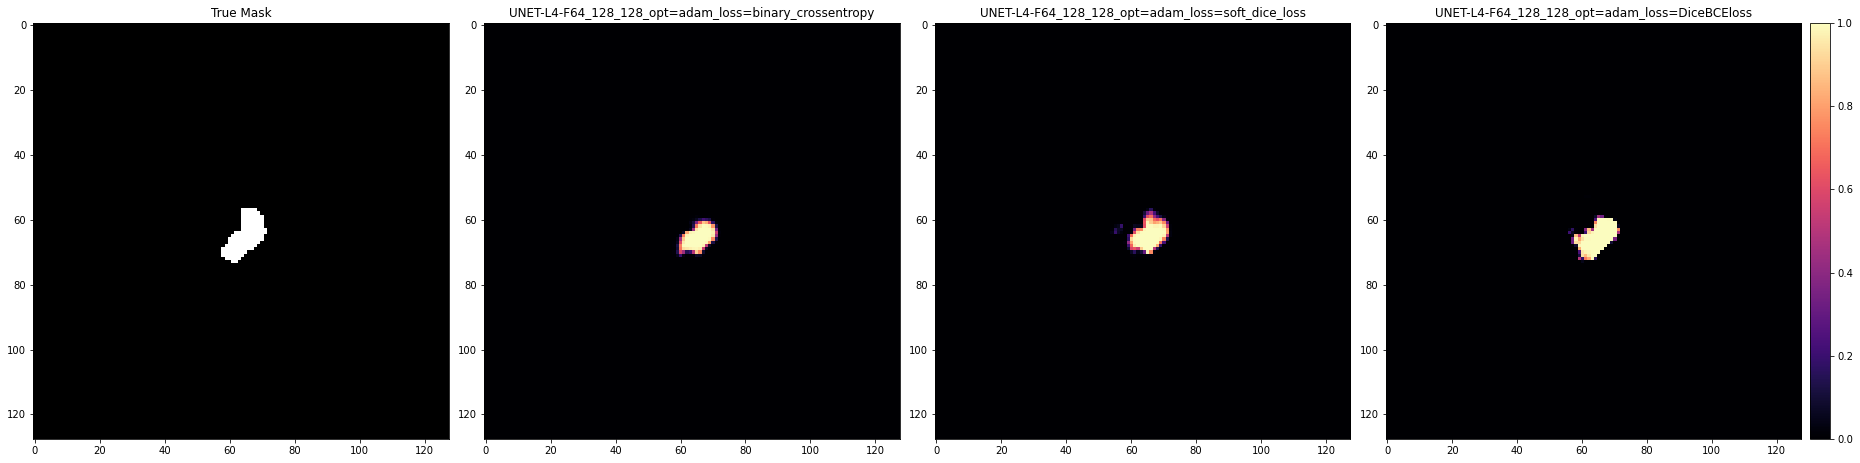

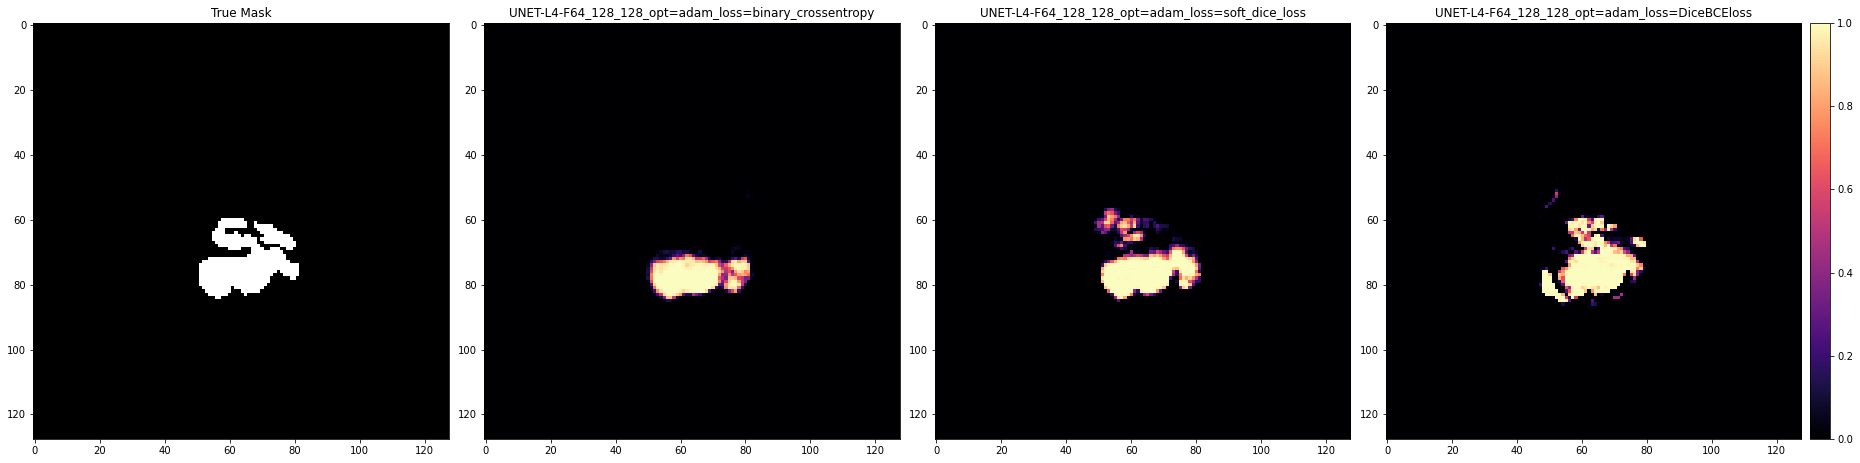

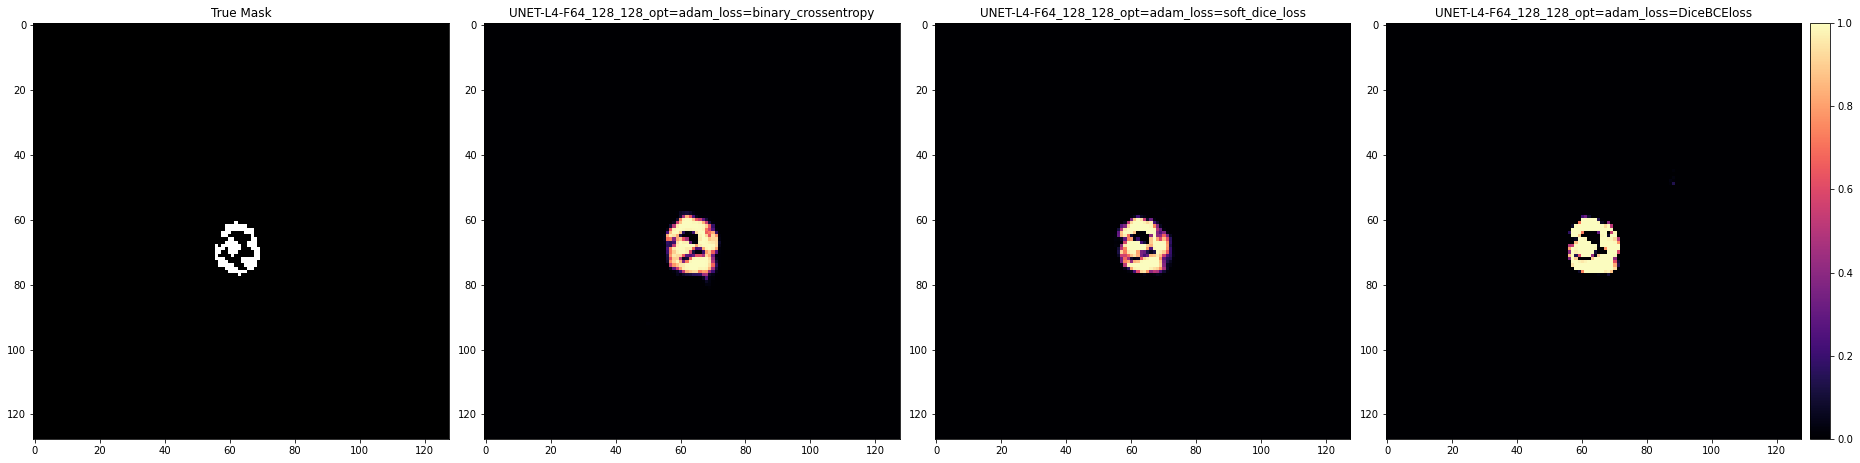

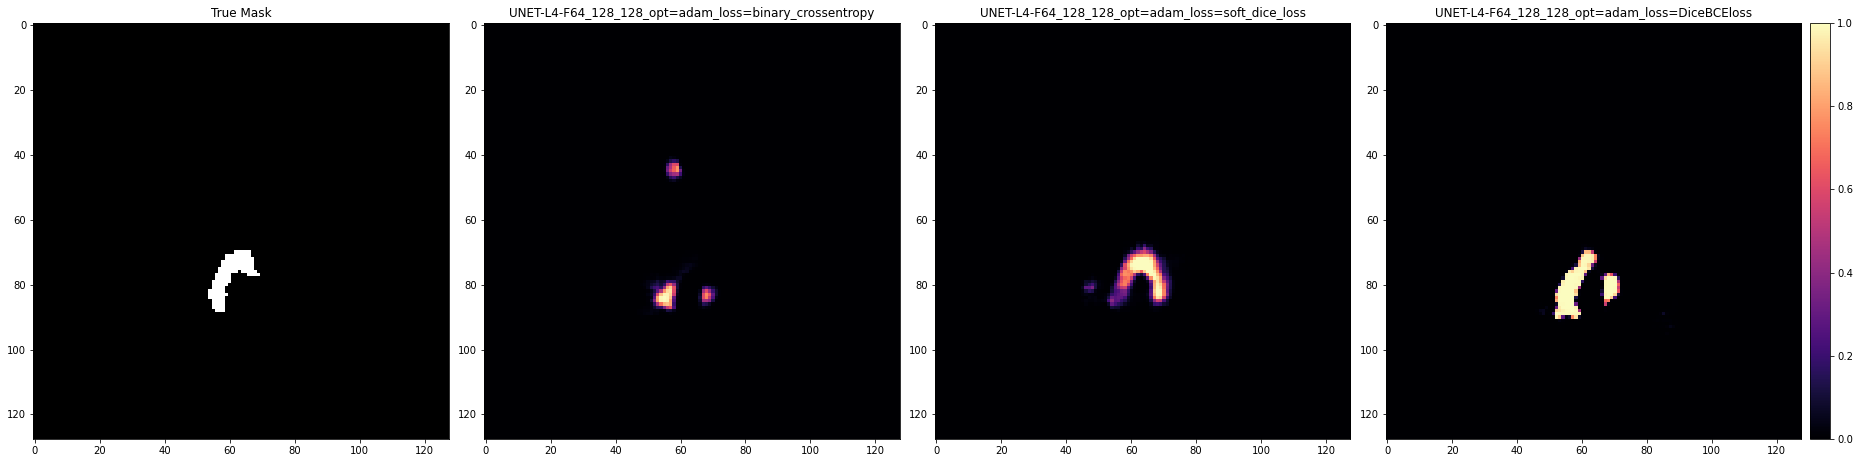

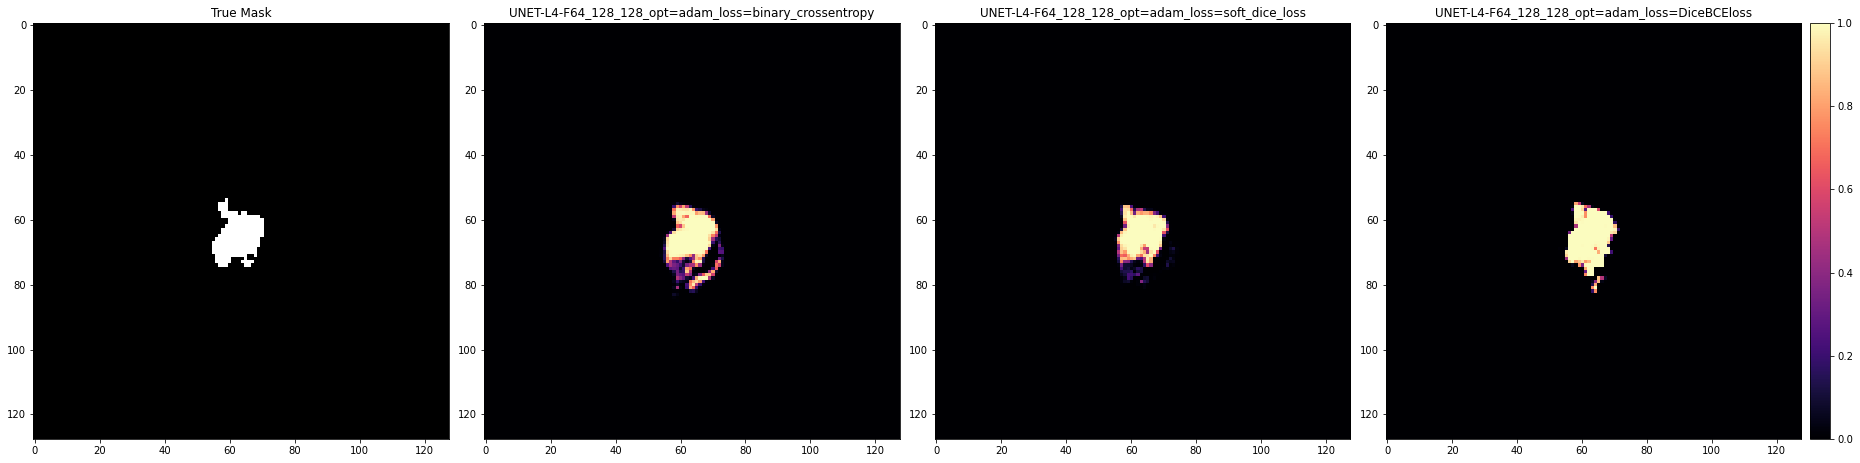

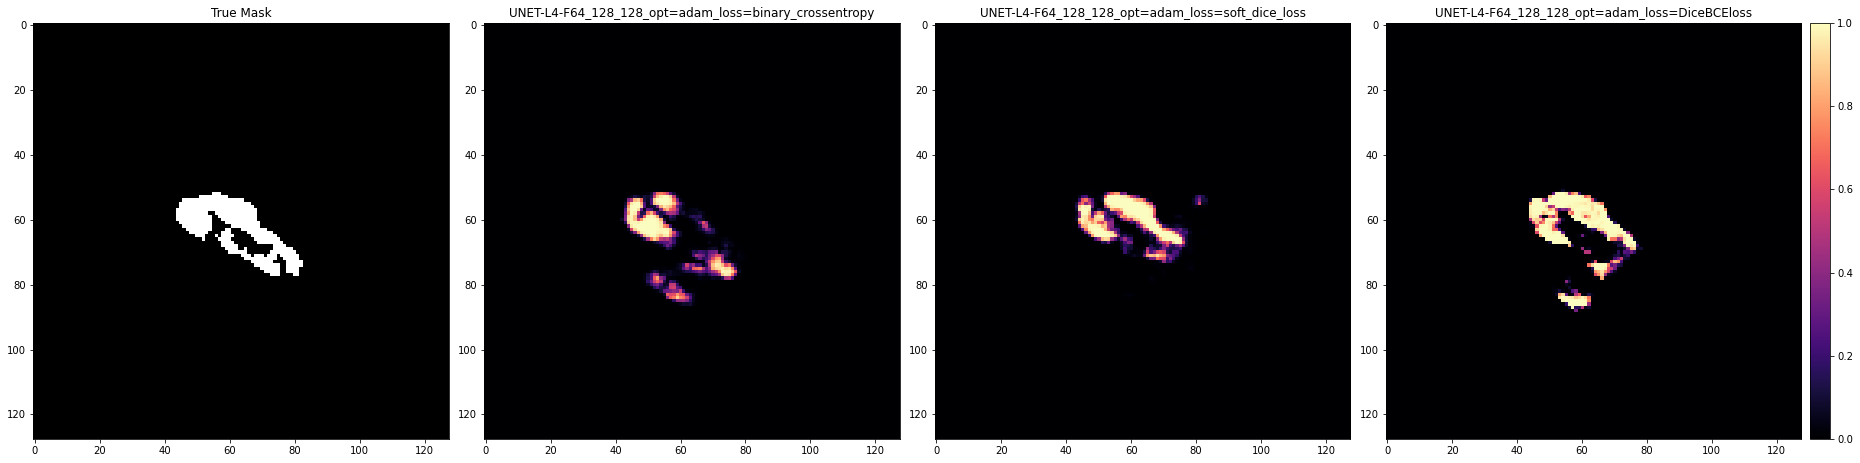

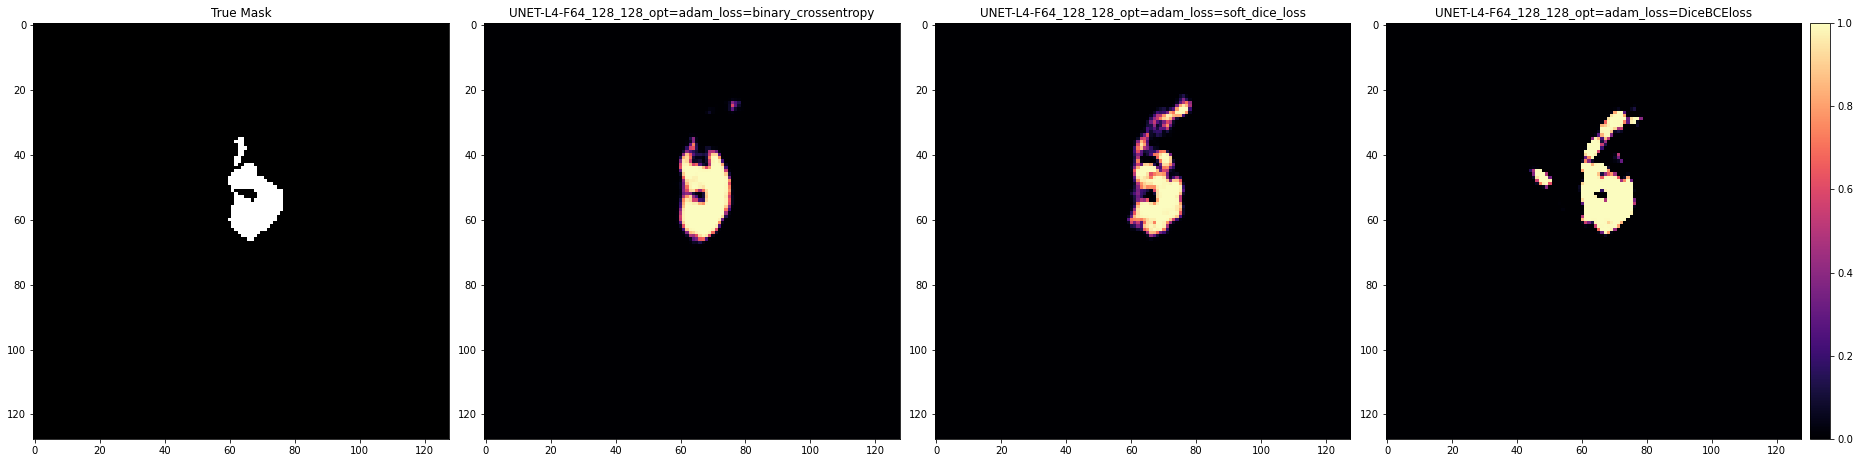

In [7]:
show_multiple_predictions(validation_generator, keys, values, 15, cmap='magma')

In [8]:
def display_overlap(display_list, keys, colormap=True, cmap='gist_heat', figsize=(25,15)):
    plt.figure(figsize=figsize, constrained_layout=True)
    title = ['True Mask'] + keys
    for i in range(1, len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        
        plt.title(title[i-1])
        if i >= 2 and colormap==True:
            ax = plt.gca()
            
            im_0 = ax.imshow(display_list[0], cmap='gray', vmin=0.0, vmax=1.0)
            
            display_list[i][display_list[i] <= 0.05 ] = np.nan
        
            im = ax.imshow(display_list[i], cmap=cmap, vmin=0.0, vmax=1.0, alpha=0.75)
            

            if i == len(display_list) - 1:

                axins = inset_axes(ax, width = "5%", height = "100%", loc = 'lower left',
                    bbox_to_anchor = (1.02, 0., 1, 1), bbox_transform = ax.transAxes,
                    borderpad = 0)
                
                plt.colorbar(im, cax=axins)
            
        else:
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i] + display_list[0]), cmap='gray') 
            # optional: tf.keras.preprocessing.image.array_to_img, just to rescale from 0.-1. to 0-255
    
    plt.show()

def show_multiple_overlap(datagen, keys, values, num=1, colormap=True, cmap='gray', figsize=(25,15)):
    for i in range(0, num):
        image, mask = next(datagen)
        
        pred_masks = [model.predict(image) for model in values]
        disp_list =  [image[0]]+ [mask[0]] + [ pred_masks[j][0] for j in range(len(pred_masks)) ]
        display_overlap( disp_list, keys, colormap, cmap, figsize)
        plt.show()    

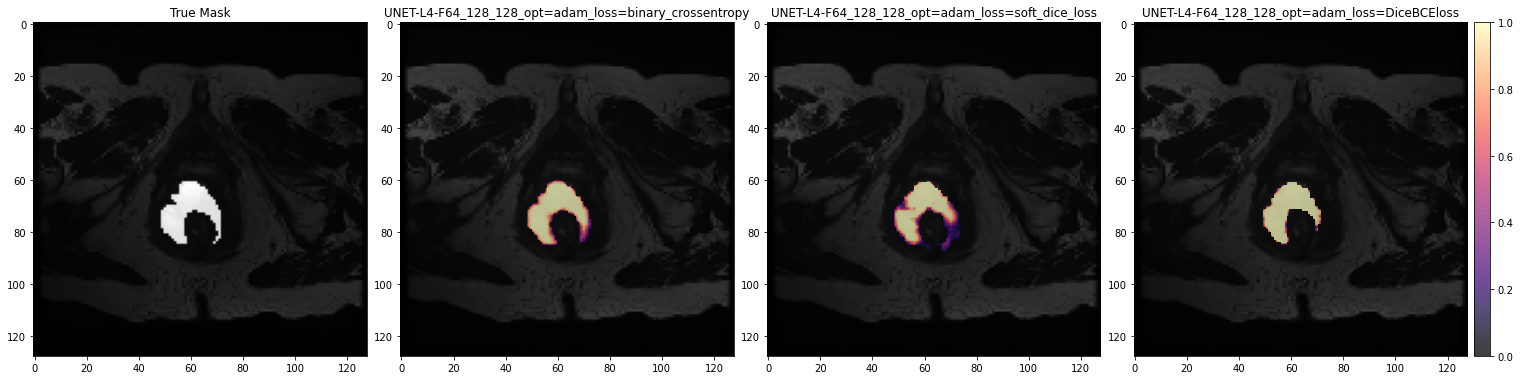

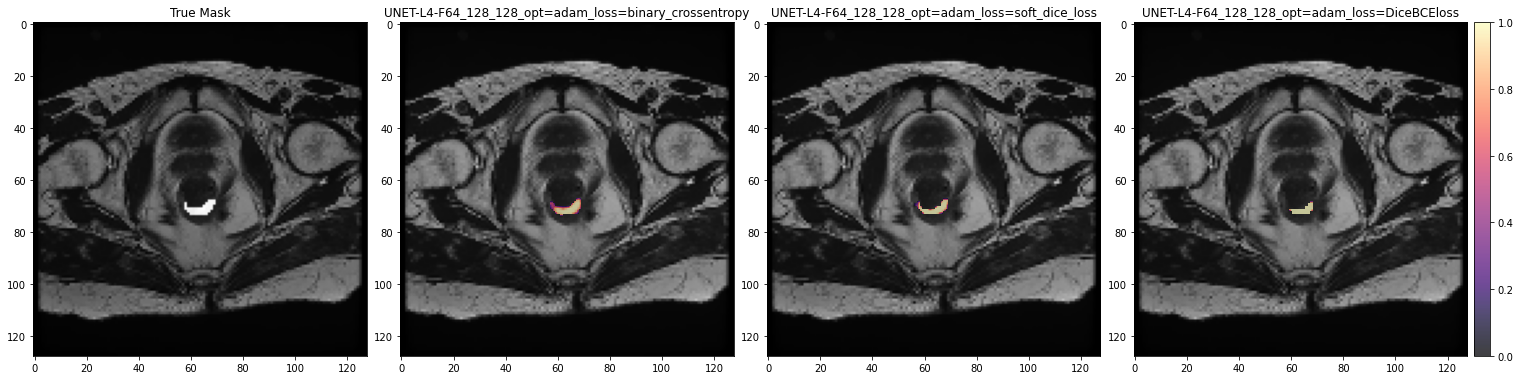

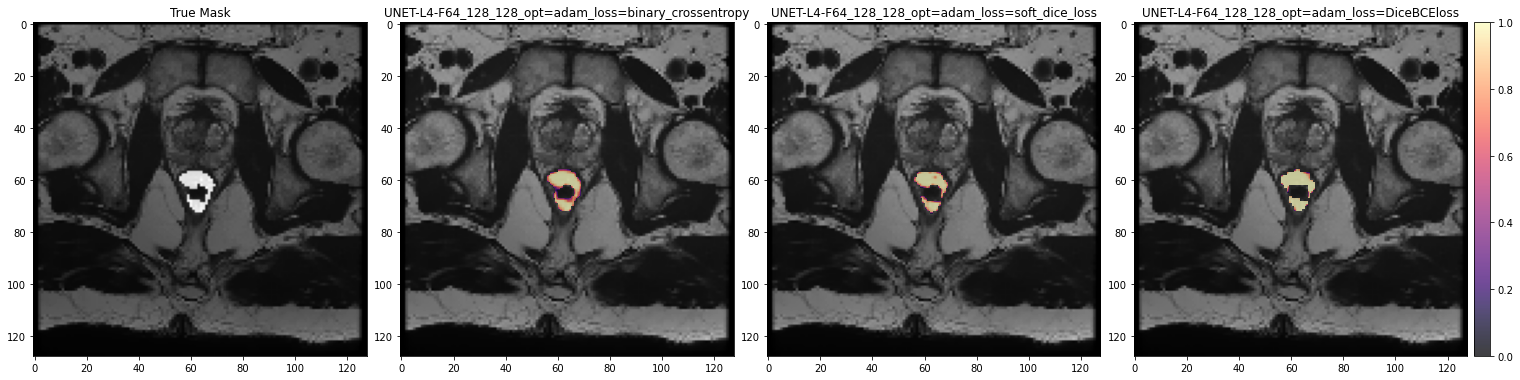

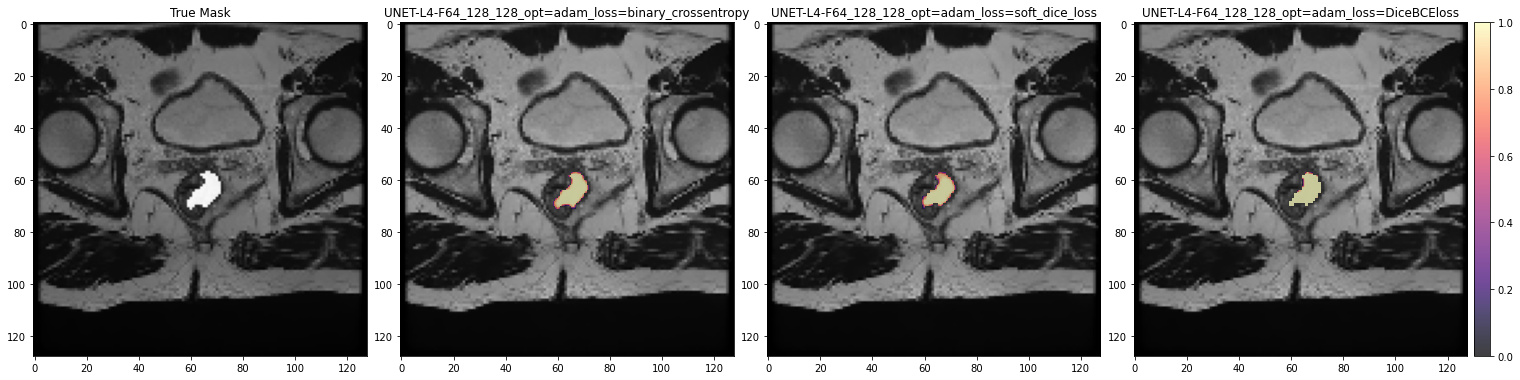

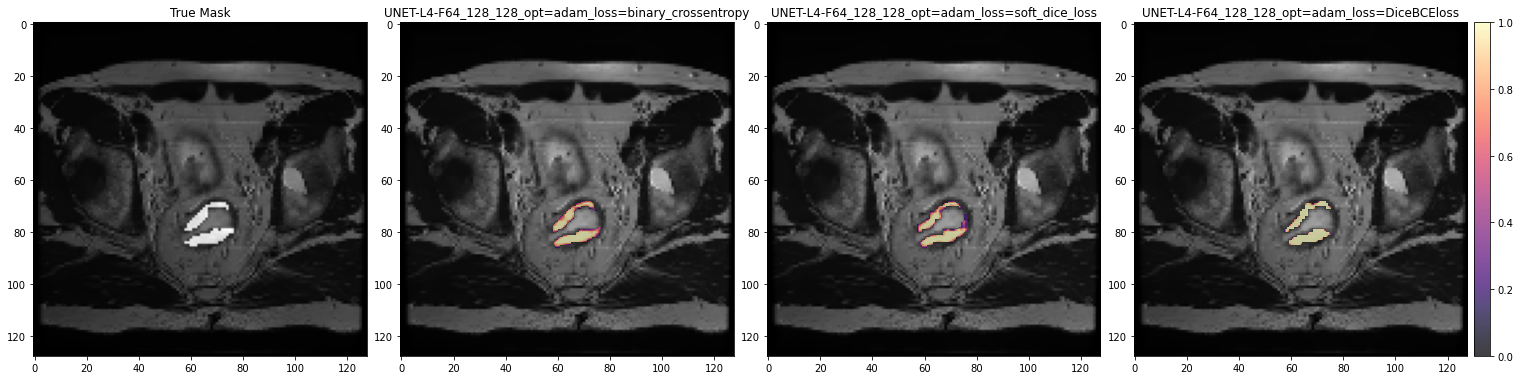

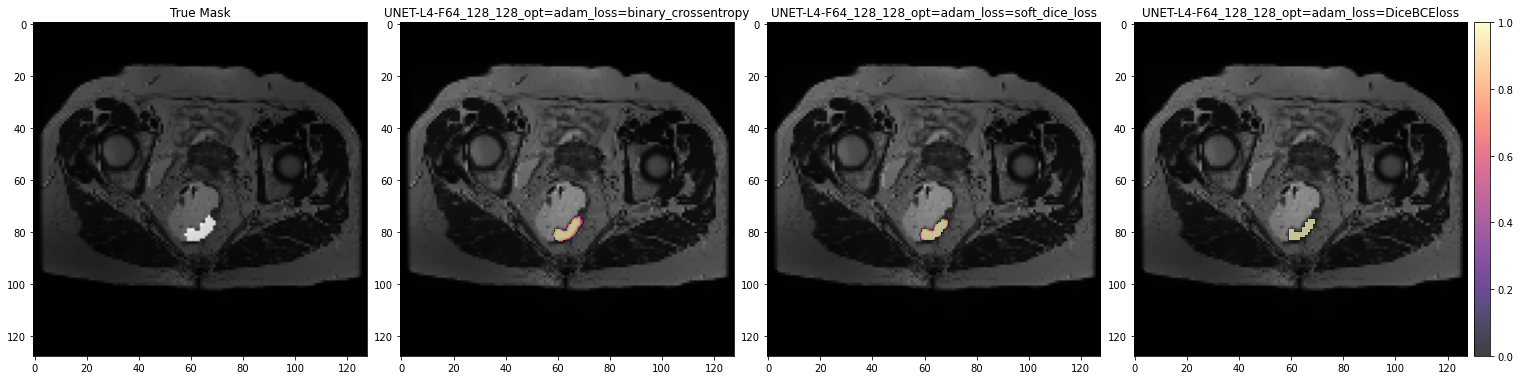

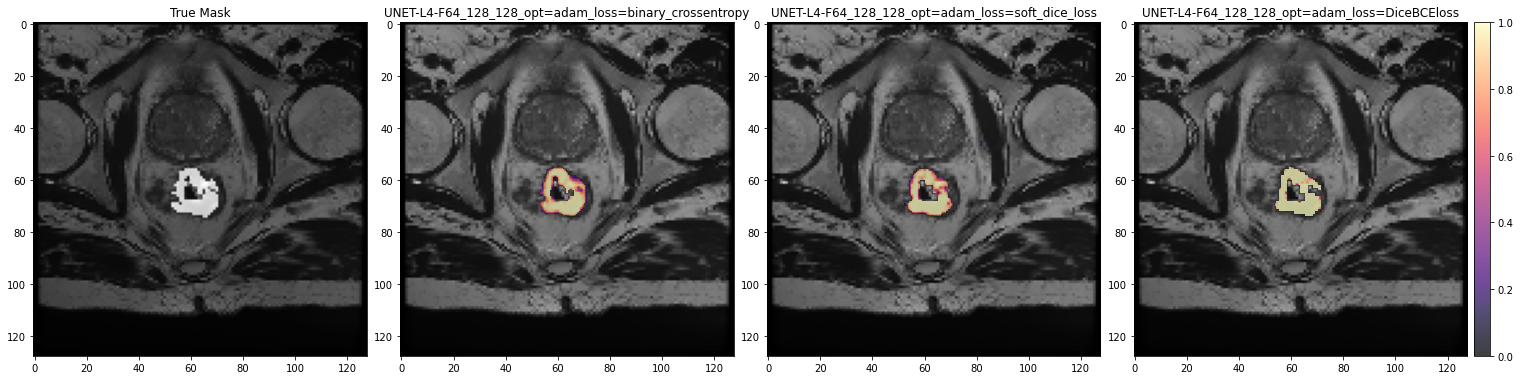

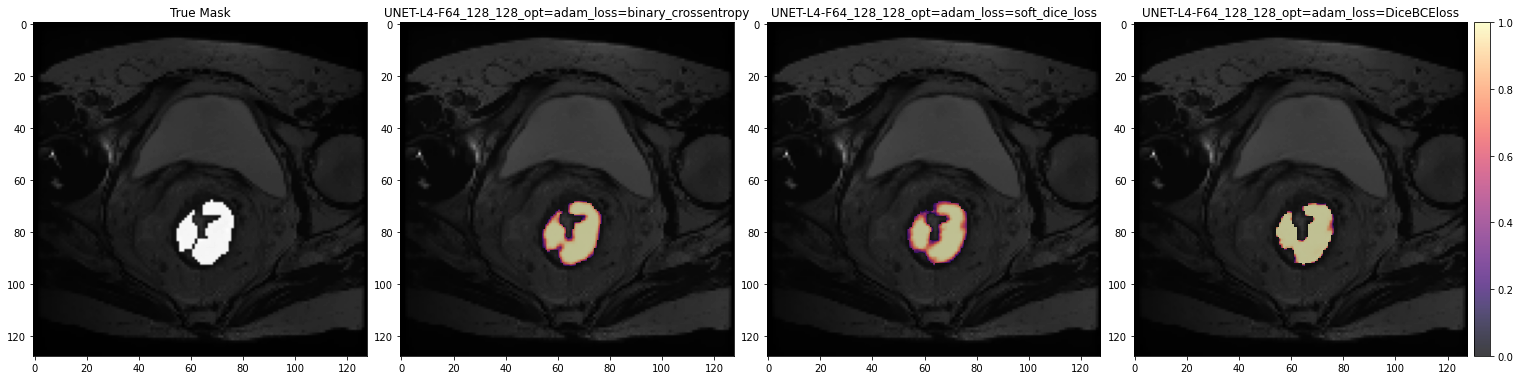

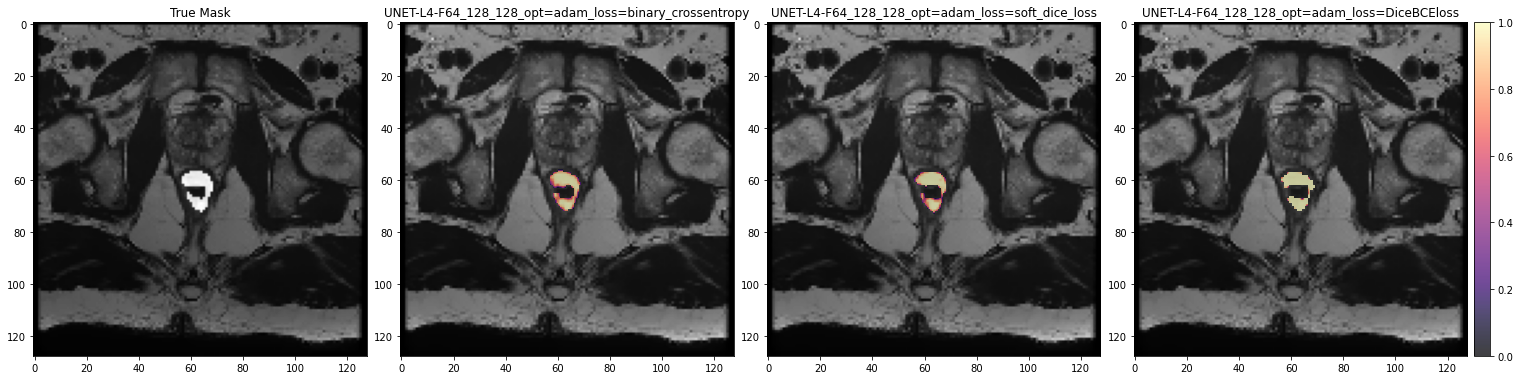

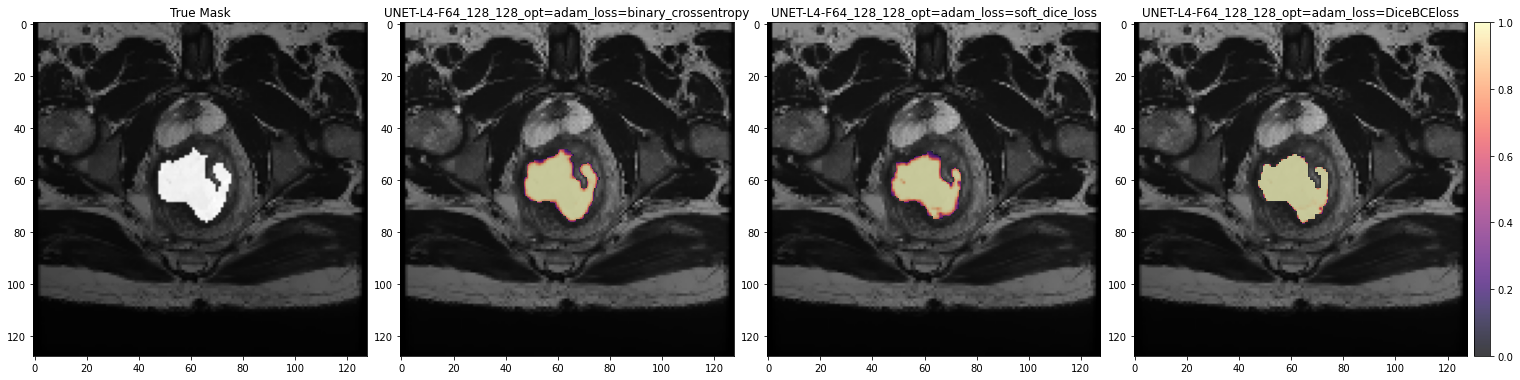

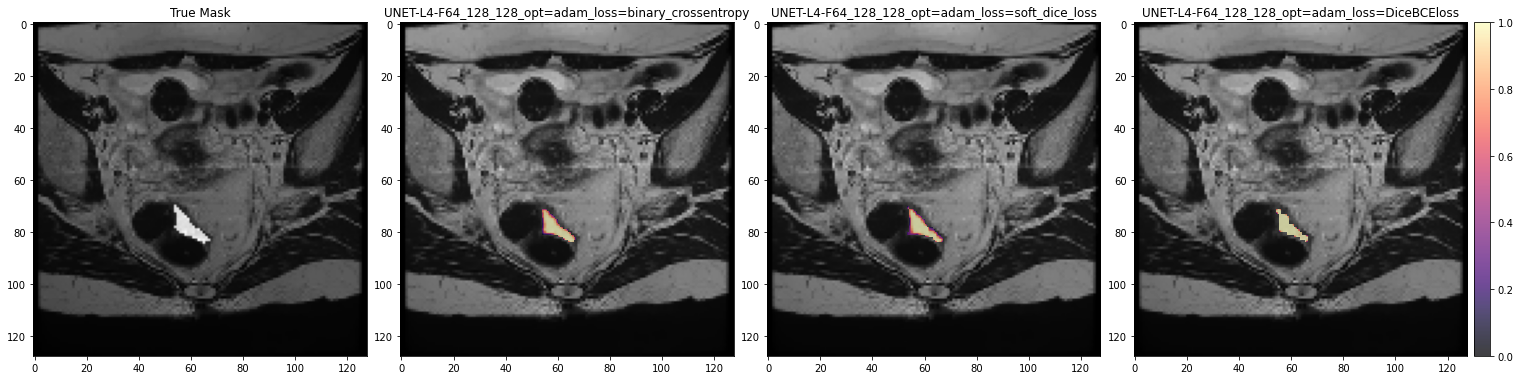

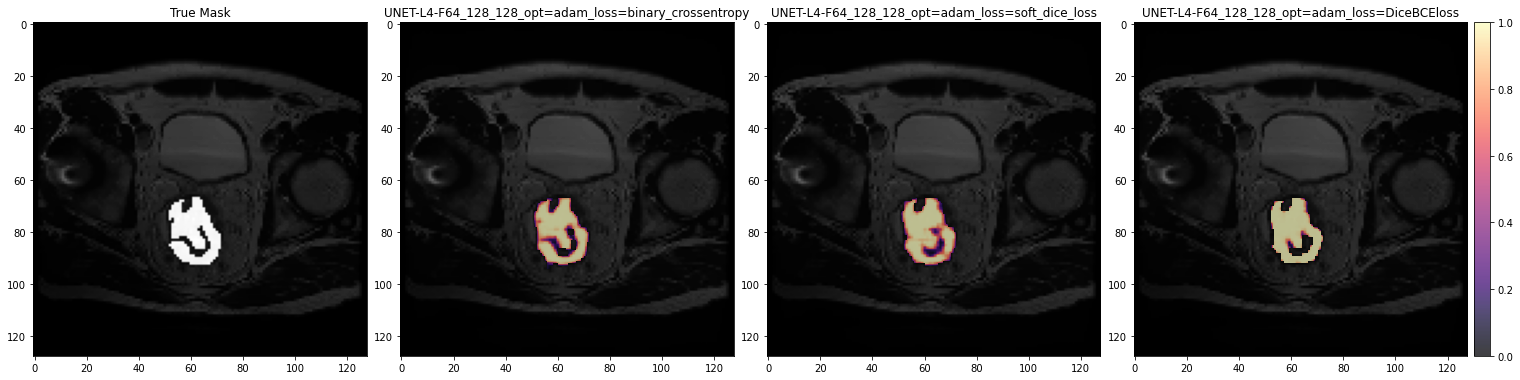

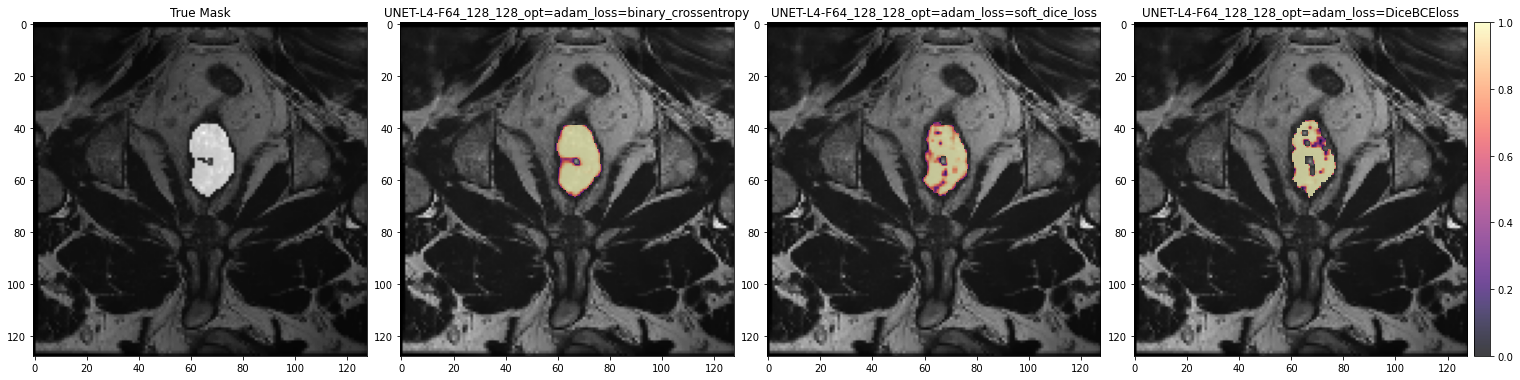

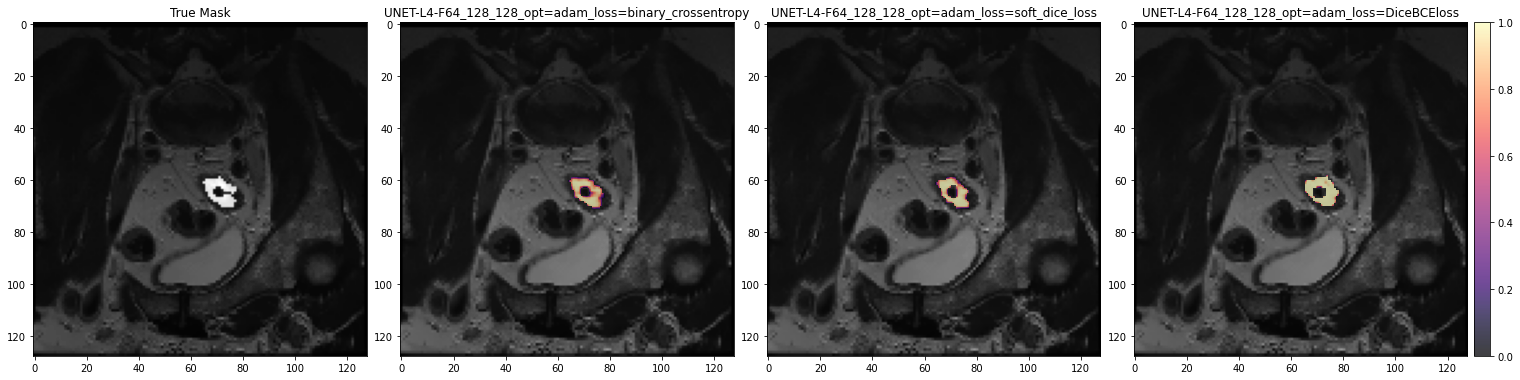

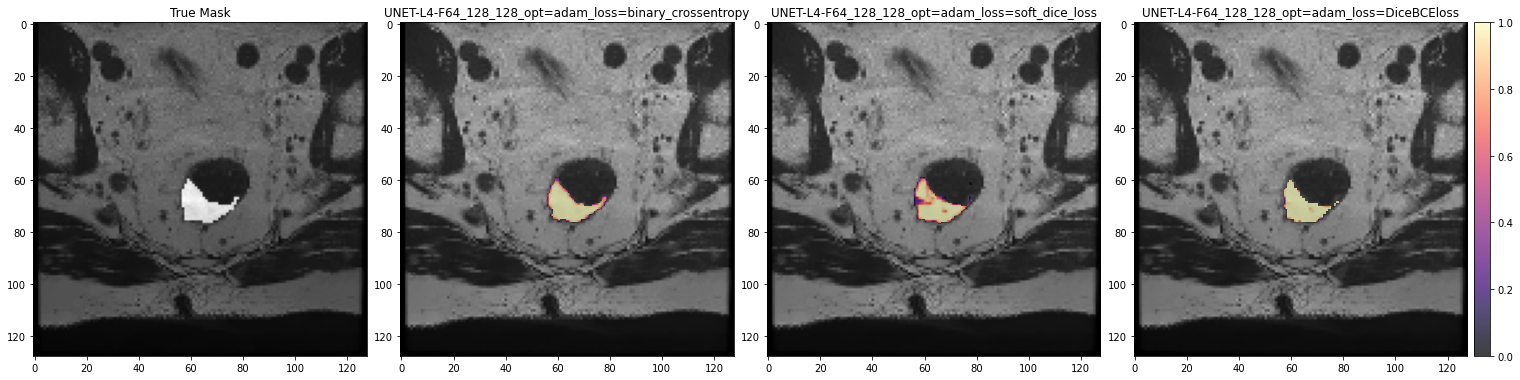

In [9]:
show_multiple_overlap(training_generator, keys, values, 15, cmap='magma')

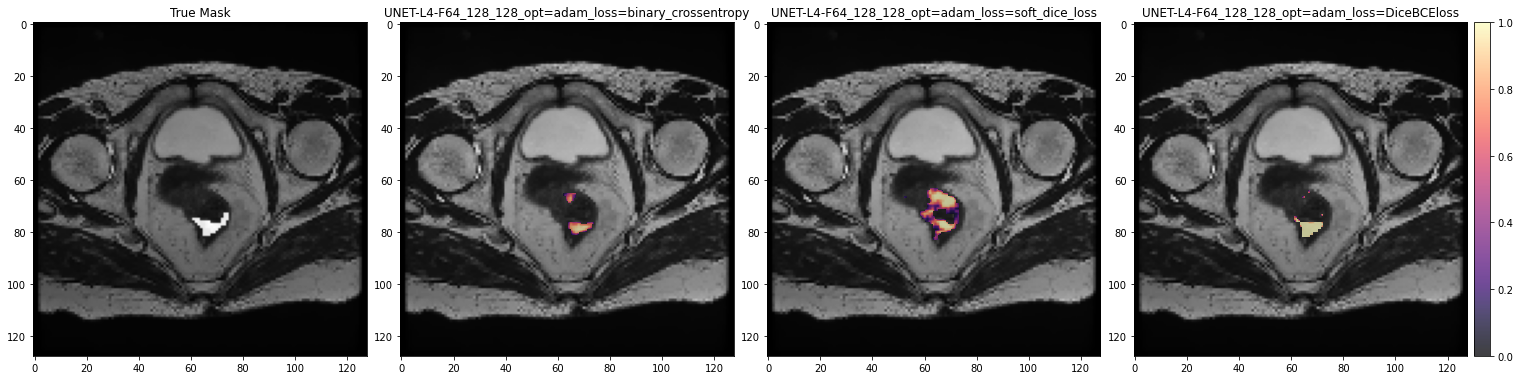

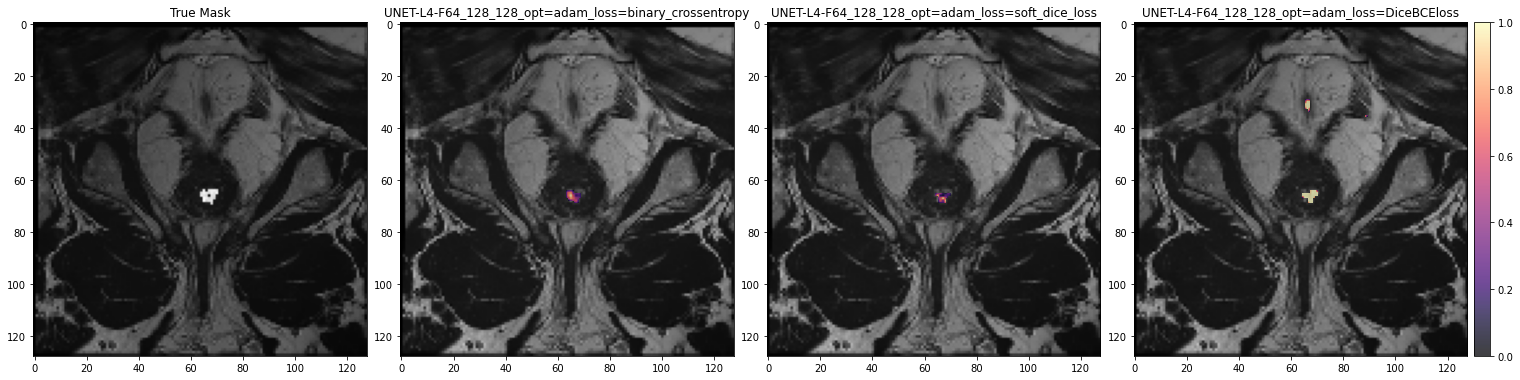

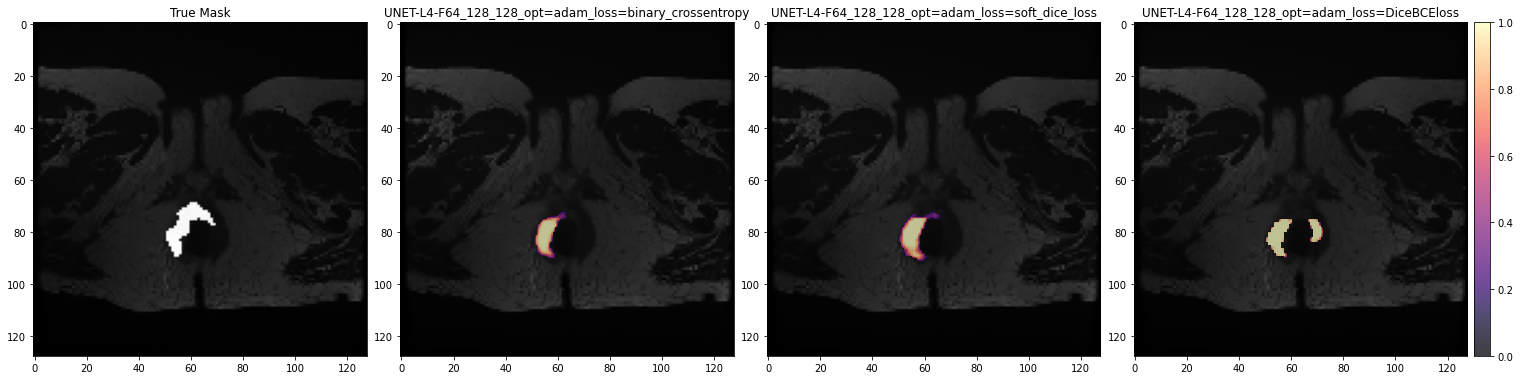

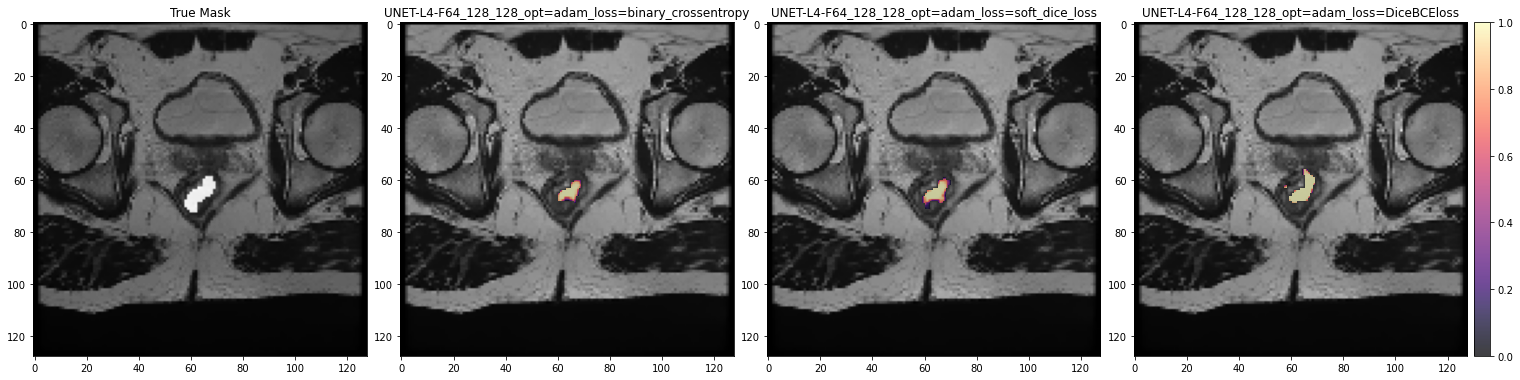

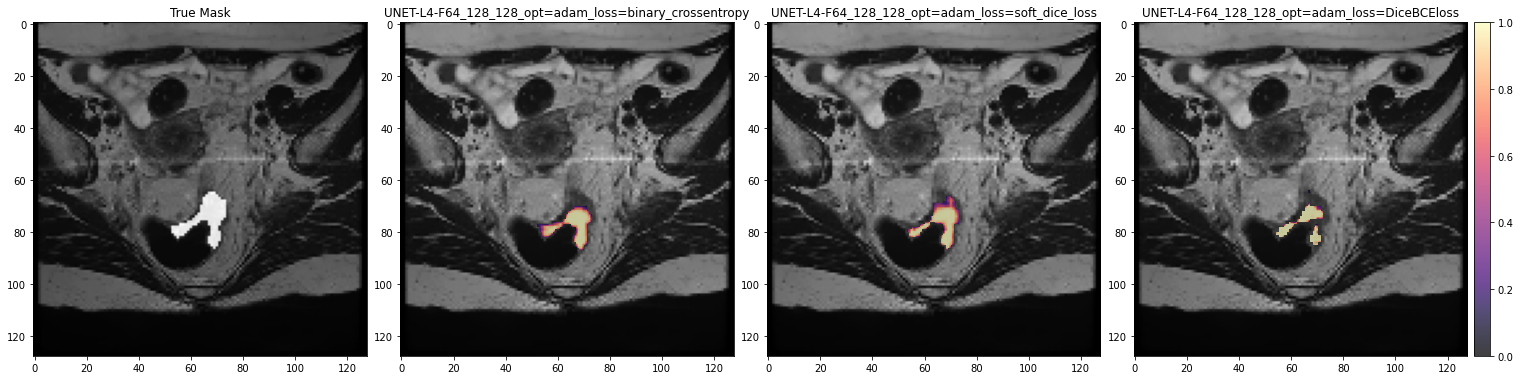

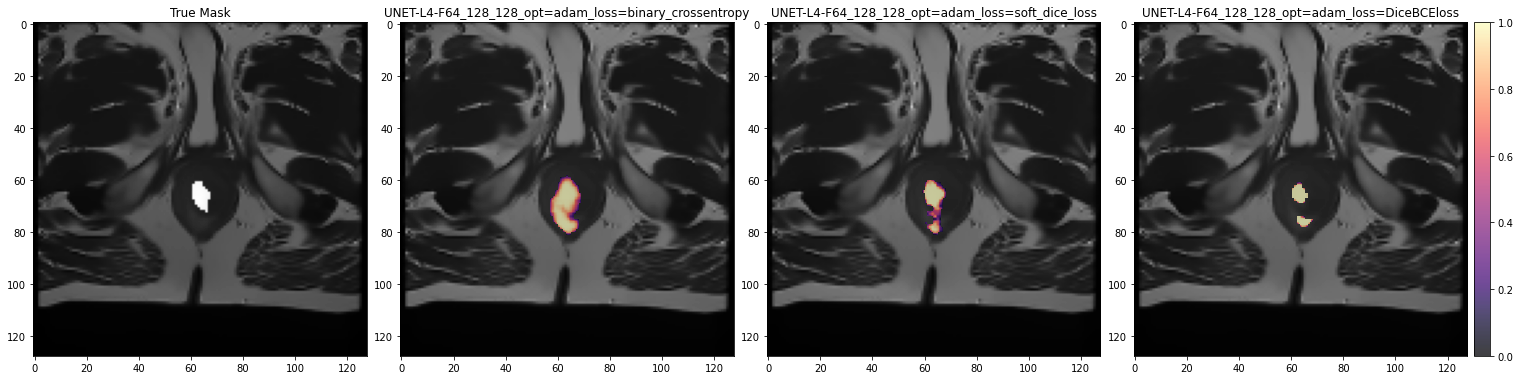

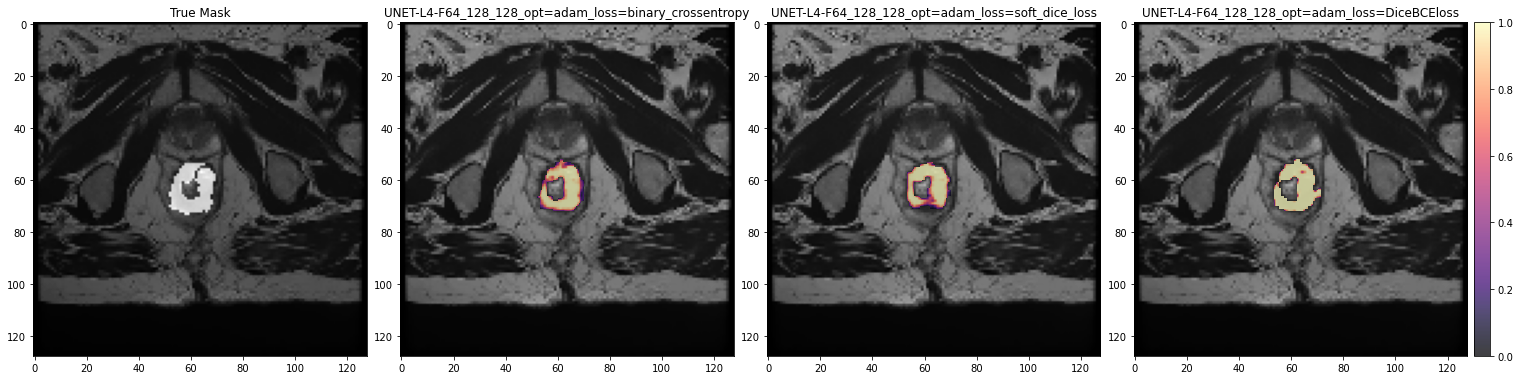

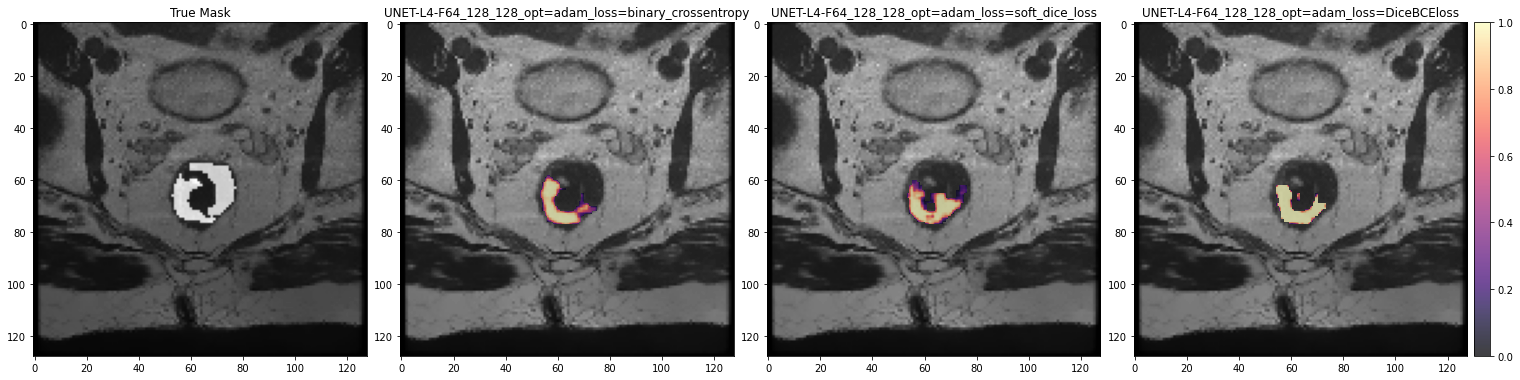

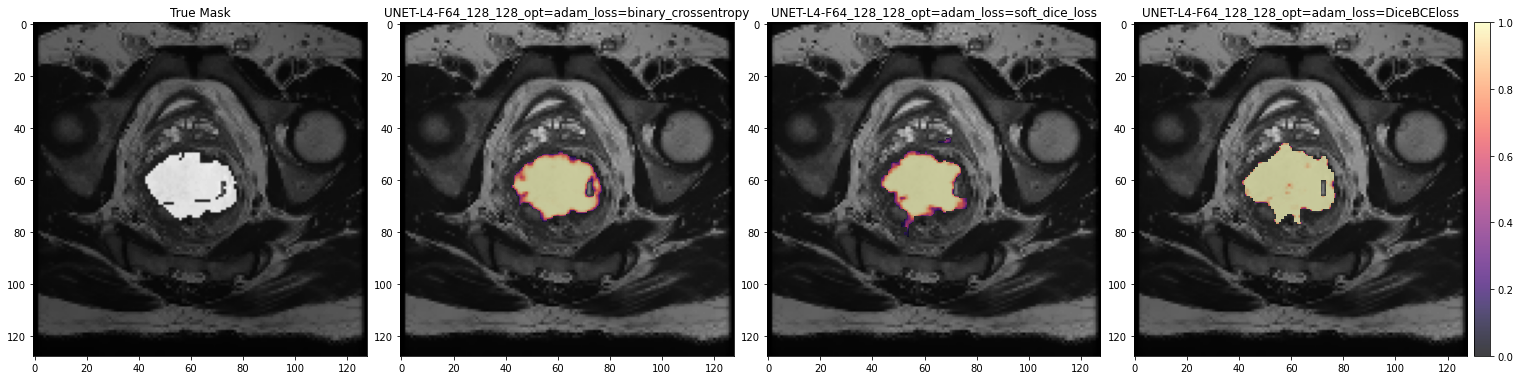

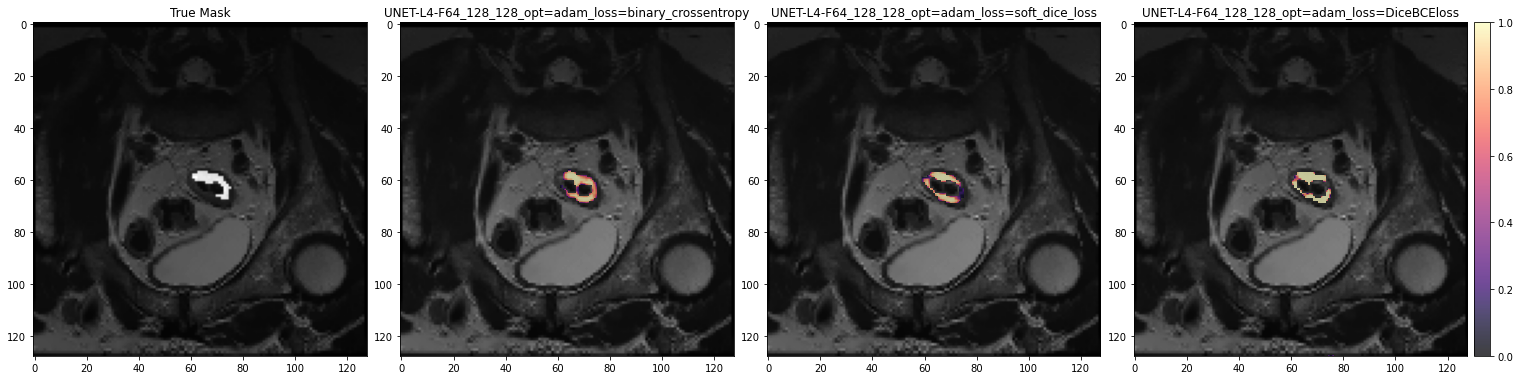

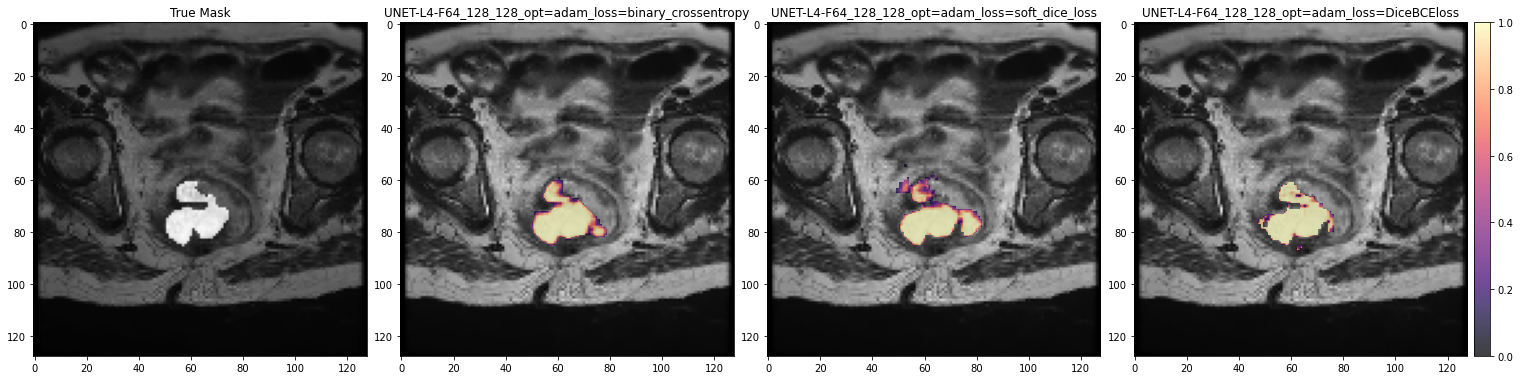

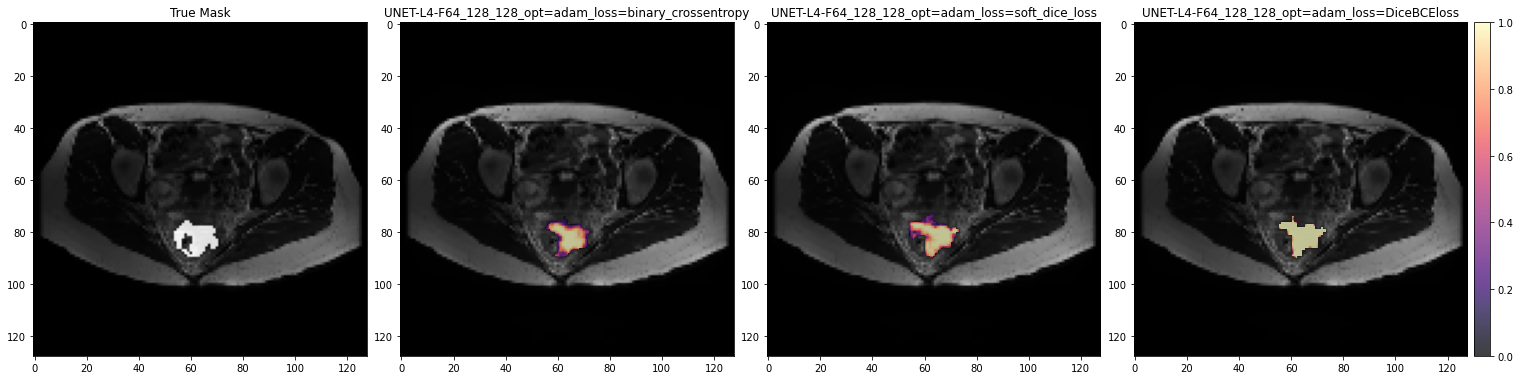

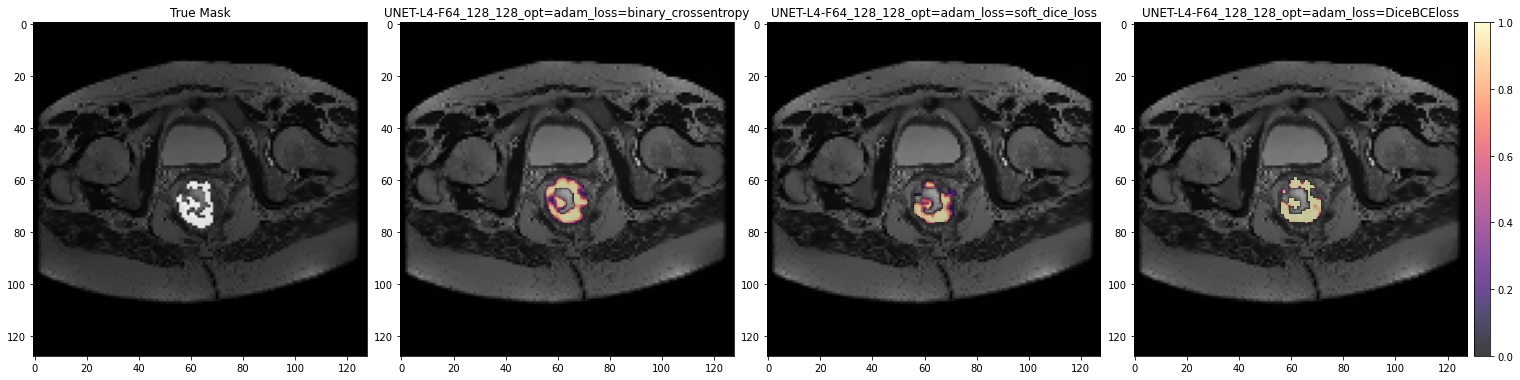

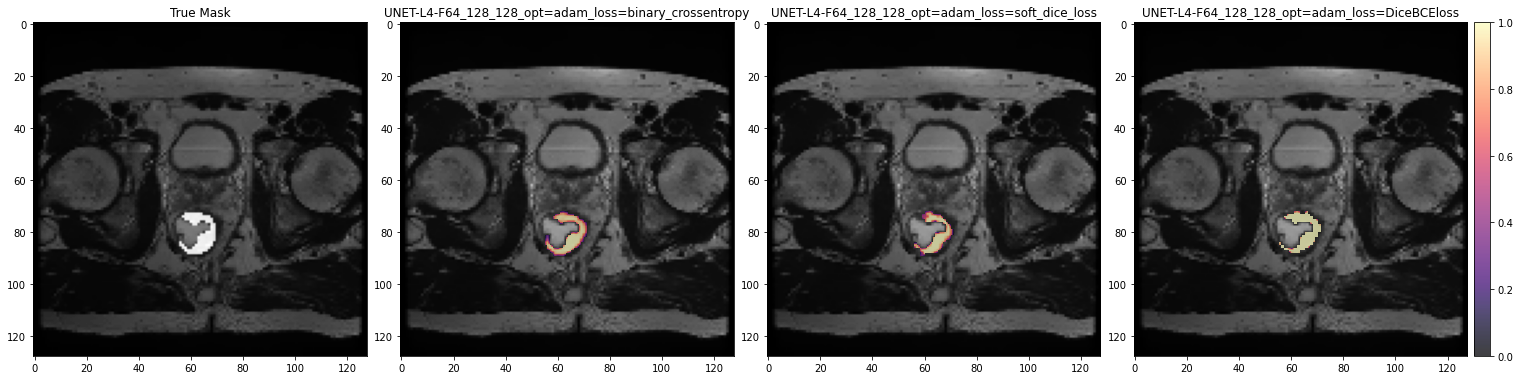

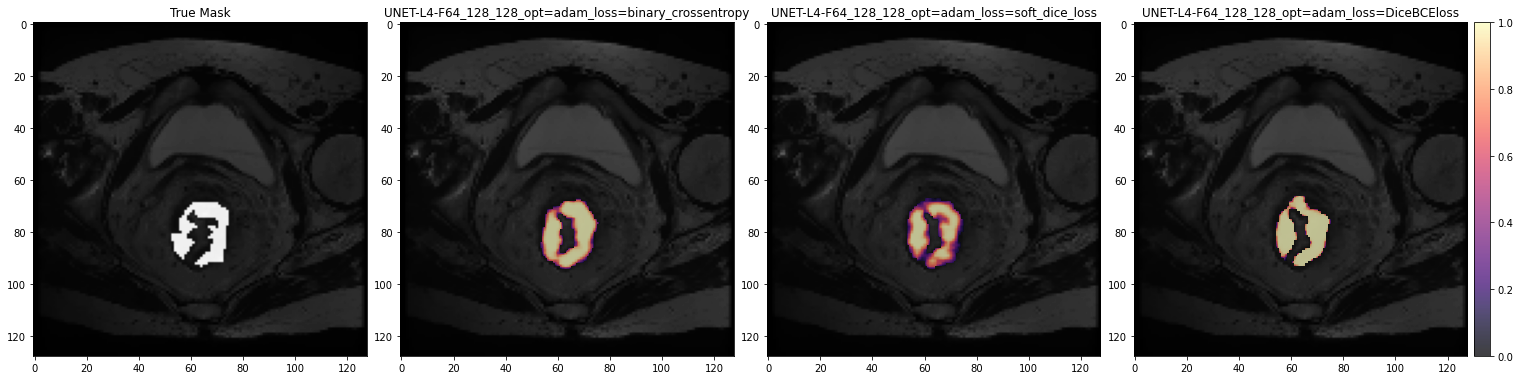

In [10]:
show_multiple_overlap(validation_generator, keys, values, 15, cmap='magma')